# Analysis of raw non-zero suppressed data
### Non-zero suppressed runs: 8088, 8089

In [1]:
from invisible_cities.cities import components as cp
from invisible_cities.reco import calib_sensors_functions as csf
from invisible_cities.database import load_db
from invisible_cities.reco import xy_algorithms as xya

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Variables to grab runs

In [2]:
num_files = 3
run_number = 8088
num_plots = 3
data_dir = '../../data/trigger1/'+str(run_number)+'/'
file_start = 'run_'+str(run_number)+'_000'
file_end = '_trigger1_waveforms.h5'
files = [data_dir+file_start+str(i+1)+file_end for i in range(0,num_files)]

### Print File Format

In [3]:
i = 0
wfs = cp.wf_from_files(files, cp.WfType.rwf)
try:
    while wfs and i < 1:
        thisdata = next(wfs)
        keys = thisdata.keys()
        print('Keys:', keys)
        for key in keys:
            print(key, type(thisdata[key]))
            print('    ', np.shape(thisdata[key]))
            print('              ', thisdata[key])
        i += 1
except StopIteration:
    pass
finally:
    del wfs

Keys: dict_keys(['pmt', 'sipm', 'run_number', 'event_number', 'timestamp', 'trigger_type', 'trigger_channels'])
pmt <class 'numpy.ndarray'>
     (12, 64000)
               [[3140 3140 3140 ... 3139 3139 3140]
 [3164 3164 3165 ... 3165 3165 3166]
 [3146 3145 3146 ... 3146 3145 3147]
 ...
 [3158 3158 3158 ... 3157 3157 3157]
 [3196 3198 3197 ... 3197 3199 3198]
 [3175 3174 3176 ... 3175 3176 3176]]
sipm <class 'numpy.ndarray'>
     (1792, 1600)
               [[50 65 56 ... 52 54 51]
 [50 53 65 ... 51 52 50]
 [60 53 51 ... 50 52 51]
 ...
 [50 49 49 ... 49 50 49]
 [50 48 60 ... 49 49 48]
 [51 48 48 ... 49 50 49]]
run_number <class 'numpy.int32'>
     ()
               8088
event_number <class 'numpy.int32'>
     ()
               157
timestamp <class 'numpy.uint64'>
     ()
               1594458917438
trigger_type <class 'numpy.int32'>
     ()
               1
trigger_channels <class 'numpy.ndarray'>
     (12,)
               [1 0 1 0 0 0 0 0 0 0 0 0]


### Collect data into numpy array

In [4]:
i = 0
events = []
wfs = cp.wf_from_files(files, cp.WfType.rwf)
try:
    while wfs:# and i < 10:
        thisdata = next(wfs)
        events.append(thisdata['sipm'])
        i += 1
except StopIteration:
    pass
finally:
    del wfs
events = np.array(events)
print('Number of Events: '+str(len(events)))

Number of Events: 462


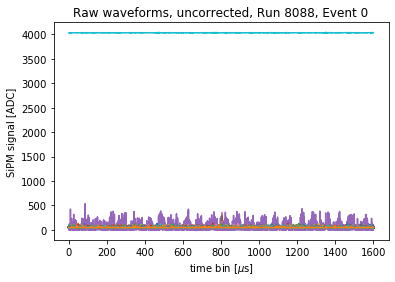

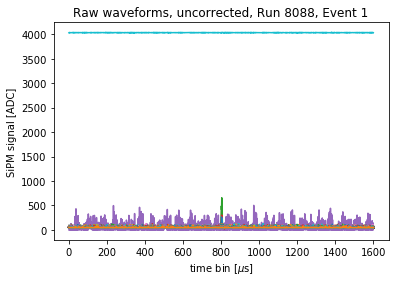

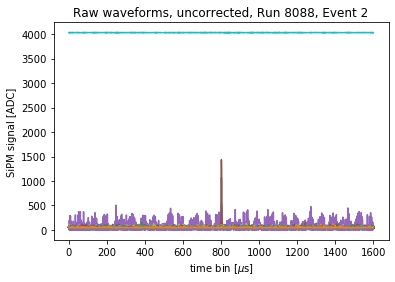

In [5]:
# Plotting a few raw waveforms, without any corrections
for event in range(0,num_plots):
    #summed_sipms = np.sum(events[event], axis=1)
    for sipm in events[event]:
        plt.plot(sipm)
    plt.xlabel(r'time bin [$\mu$s]')
    plt.ylabel('SiPM signal [ADC]')
    plt.title('Raw waveforms, uncorrected, Run '+str(run_number)+', Event '+str(event))
    #plt.xlim(640,660)
    #plt.ylim(60000,100000)
    plt.show()

### Finding the noisy SiPMs

In [6]:
np.shape(events)

(462, 1792, 1600)

In [7]:
pedestals = np.mean(events, axis=2) # shape: (events, sipms)
event_std = np.std(events, axis=2) # shape: (events, sipms)

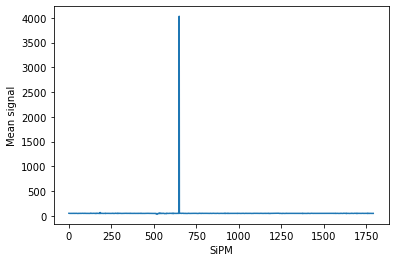

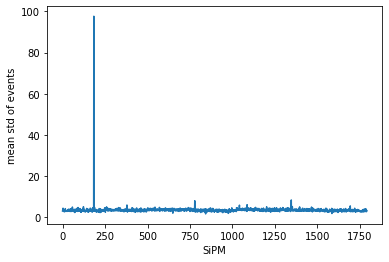

In [8]:
plt.plot(np.mean(pedestals, axis=0))
plt.xlabel('SiPM')
plt.ylabel('Mean signal')
plt.show()

plt.plot(np.mean(event_std, axis=0))
plt.xlabel('SiPM')
plt.ylabel('mean std of events')
plt.show()

In [9]:
bad_sipms = []
for event in range(0,len(events)):
    for sipm in range(len(events[event])):
        mean = np.mean(events[event][sipm])
        std = np.std(events[event][sipm])
        if mean > 70 or std > 70:
            bad_sipms.append(sipm)

worst_sipms = []
for sipm in np.unique(bad_sipms):
    count = np.count_nonzero(bad_sipms == sipm)
    print('SiPM '+str(sipm)+' suspicious in '+str(count)+' events')
    if count == len(events):
        worst_sipms.append(sipm)
print(worst_sipms)

SiPM 184 suspicious in 462 events
SiPM 412 suspicious in 1 events
SiPM 418 suspicious in 1 events
SiPM 649 suspicious in 462 events
SiPM 721 suspicious in 1 events
SiPM 732 suspicious in 1 events
SiPM 794 suspicious in 1 events
[184, 649]


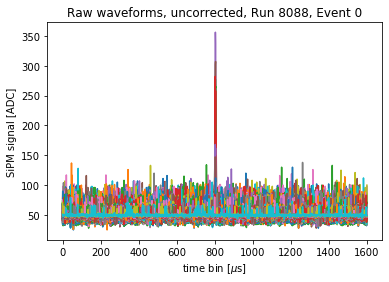

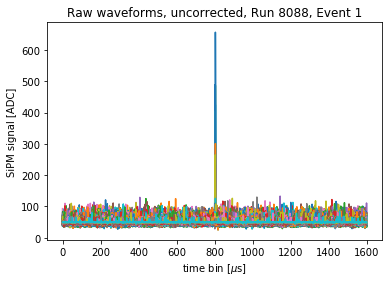

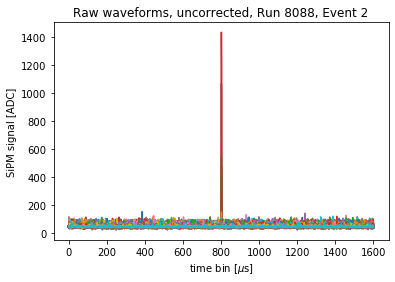

In [10]:
# Plotting a few raw waveforms, without any corrections
events_bad_sipms = events
events = np.delete(events_bad_sipms, worst_sipms, axis=1)
for event in range(0,num_plots):
    for sipm in range(len(events[event])):
        plt.plot(events[event][sipm])
    plt.xlabel(r'time bin [$\mu$s]')
    plt.ylabel('SiPM signal [ADC]')
    plt.title('Raw waveforms, uncorrected, Run '+str(run_number)+', Event '+str(event))
    #plt.xlim(640,660)
    #plt.ylim(60000,100000)
    plt.show()

### Calibrate: remove pedestal and convert to pes

In [11]:
sipm_thr = 0
detector_db = 'new'
cal_sipms = cp.calibrate_sipms(detector_db, run_number, sipm_thr)
calibrated_sipms = np.array([cal_sipms(wfs) for wfs in events_bad_sipms])
calibrated_bad_sipms = calibrated_sipms
calibrated_sipms = np.delete(calibrated_sipms, worst_sipms, axis=1)

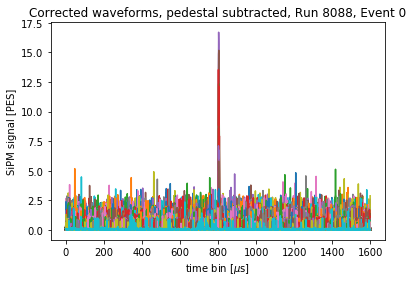

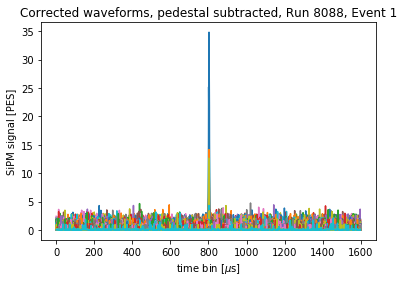

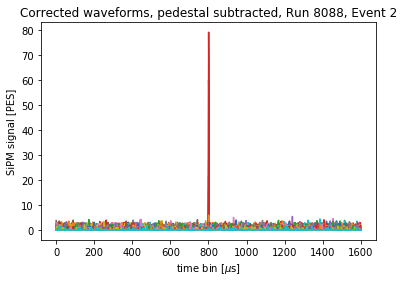

In [12]:
# Plotting a few waveforms, pedestal subtracted, calibrated
for event in range(0,num_plots):
    for sipm in range(len(calibrated_sipms[event])):
        plt.plot(calibrated_sipms[event][sipm])
    #plt.ylim(-.2,.2)
    plt.xlabel(r'time bin [$\mu$s]')
    plt.ylabel('SiPM signal [PES]')
    plt.title('Corrected waveforms, pedestal subtracted, Run '+str(run_number)+', Event '+str(event))
    #plt.xlim(780,825)
    #plt.ylim(60000,100000)
    plt.show()

### Find average waveform

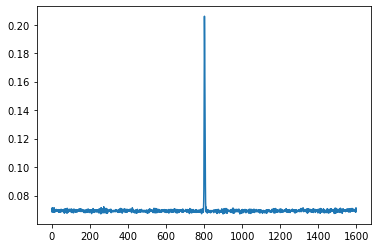

In [13]:
ave_waveform = np.mean(np.mean(calibrated_sipms, axis=1), axis=0)
plt.plot(ave_waveform)

(0.0, 0.25)

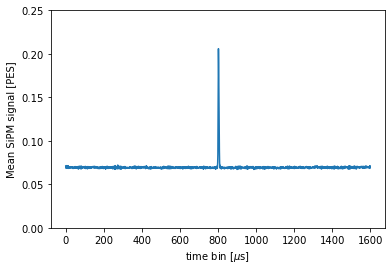

In [14]:
plt.plot(ave_waveform)
plt.xlabel(r'time bin [$\mu$s]')
plt.ylabel('Mean SiPM signal [PES]')
plt.ylim(0.,0.25)

(798, 808)

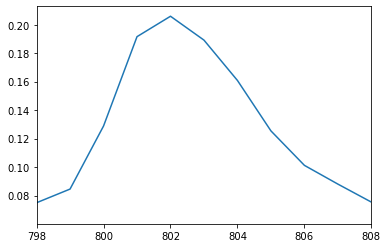

In [15]:
# Zooming into peak
plt.plot(ave_waveform)
plt.xlim(798,808)

Mean signal 
    inside S2 window = 0.13505488754325698
    outside window = 0.06910722377363447


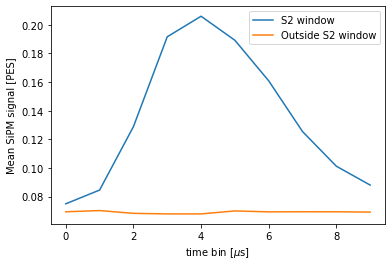

In [16]:
s2_window = [798,808]
outer_window = [1000,1010]
print('Mean signal \n    inside S2 window = '+str(ave_waveform[s2_window[0]:s2_window[1]].mean())
      + '\n    outside window = '+str(ave_waveform[outer_window[0]:outer_window[1]].mean()))
plt.plot(ave_waveform[s2_window[0]:s2_window[1]], label="S2 window")
plt.plot(ave_waveform[outer_window[0]:outer_window[1]], label="Outside S2 window")
plt.xlabel(r'time bin [$\mu$s]')
plt.ylabel('Mean SiPM signal [PES]')
plt.legend()
plt.show()

### What is the probability of a sipm having signal higher than a given value?

In [68]:
event_charge = np.sum(np.sum(sipms_s2, axis=2), axis=1)

In [ ]:
rs = np.sqrt(sipm_xys[max_sipms][:,0]**2 + sipm_xys[max_sipms][:,1]**2)
calibrated_rcut_sipms = calibrated_sipms[np.argwhere(rs > 100)]

In [62]:
event_charge_rcut = np.sum(np.sum(calibrated_rcut_sipms[:,0,:,798:808], axis=2), axis=1)

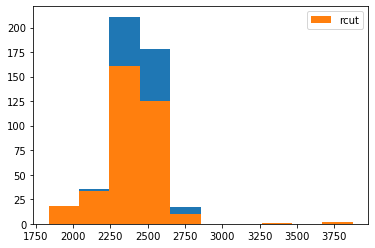

In [69]:
plt.hist(event_charge)
plt.hist(event_charge_rcut, label='rcut')
plt.legend()
plt.show()

In [17]:
# Testing for one event and one sipm
event = 0
sipm_thresh = .1
sipm_num = 0
this_sipm_s2 = calibrated_sipms[event][:,s2_window[0]:s2_window[1]][sipm_num,:]
prob_sipm_signal = len(this_sipm_s2[this_sipm_s2 > sipm_thresh])/len(this_sipm_s2)

In [18]:
# testing how it scales with other events and sipms
this_sipm_s2 = calibrated_sipms[:,:,s2_window[0]:s2_window[1]][:,sipm_num,:]
print(np.mean(this_sipm_s2 > sipm_thresh, axis=1).mean())
print(np.mean(this_sipm_s2 > sipm_thresh))

0.25627705627705627
0.25627705627705627


In [19]:
# Making event window for sipms and testing with single threshold
sipms_s2 = calibrated_sipms[:,:,s2_window[0]:s2_window[1]]
prob_sipms_signal_s2 = np.mean(sipms_s2 > sipm_thresh)
total_charge_s2 = np.sum(sipms_s2 > sipm_thresh)

sipms_outer = calibrated_sipms[:,:,outer_window[0]:outer_window[1]]
prob_sipms_signal_outer = np.mean(sipms_outer > sipm_thresh)
total_charge_outer = np.sum(sipms_outer > sipm_thresh)

print('Probs:' ,prob_sipms_signal_s2, prob_sipms_signal_outer)
print('Total charge', total_charge_s2, total_charge_outer)

Probs: 0.257887615178118 0.20509262618201166
Total charge 2132679 1696075


In [20]:
sipms_s2 = np.array(sipms_s2)
np.shape(sipms_s2)

(462, 1790, 10)

In [21]:
np.shape(sipms_s2 > sipm_thresh)

(462, 1790, 10)

In [22]:
charge_s2 = sipms_s2
charge_s2[charge_s2<sipm_thresh] = 0
(np.sum(np.sum(charge_s2,axis=2),axis=1))

array([2194.04333749, 2395.37405702, 2416.94184435, 2359.78296094,
       2418.48376563, 2146.91919732, 2353.00369756, 2285.75404818,
       2445.69037294, 2425.49913042, 2311.95249305, 2211.2111124 ,
       2163.3212794 , 2141.80161568, 2232.92497242, 2102.42396516,
       2138.72447864, 2287.09486996, 2137.9153183 , 2444.67648546,
       2313.54867541, 1775.7015153 , 2313.90531996, 1776.98856064,
       2330.17257694, 2384.62659463, 2096.72839453, 2134.80313146,
       2363.67975047, 2005.5627788 , 2289.92142764, 2314.2346072 ,
       2429.35576025, 2215.1359916 , 2217.27820314, 2408.58087493,
       2554.78613913, 2451.61717662, 1954.91116283, 2120.94184925,
       2190.94490526, 2302.39176271, 2305.01728156, 2204.49630005,
       2296.73351301, 2085.3079692 , 2450.15747377, 2240.41379236,
       2190.25030292, 2300.66819148, 2258.23368757, 2416.12865374,
       2179.13318087, 2080.38921024, 2154.18981859, 2166.48807171,
       2344.64703968, 2135.69085064, 2374.87005731, 1989.97910

In [23]:
a = [1,2,3]
b = [4,5,6]
c = np.vstack((a,b))
d = np.ndarray.flatten(c)
c[c < 3] = 0
np.sum(c, axis=1)

array([ 3, 15])

In [24]:
# Calculating probability of a sipm having over a signal for given thresholds
sipm_thresholds = np.linspace(0,10, 10)
prob_sipms_signal_s2 = [np.mean(sipms_s2 > thresh) for thresh in sipm_thresholds]
prob_sipms_signal_outer = [np.mean(sipms_outer > thresh) for thresh in sipm_thresholds]

# Total charge in sipms over a given threshold
total_charge_s2 = []
total_charge_outer = []
for thresh in sipm_thresholds:
    copy_sipms_s2 = sipms_s2.copy()
    copy_sipms_s2[copy_sipms_s2<thresh] = 0
    total_charge_s2.append(np.mean(np.sum(np.sum(copy_sipms_s2,axis=2),axis=1)))
    
    copy_sipms_outer = sipms_outer.copy()
    copy_sipms_outer[copy_sipms_outer<thresh] = 0
    total_charge_outer.append(np.mean(np.sum(np.sum(copy_sipms_outer,axis=2),axis=1)))

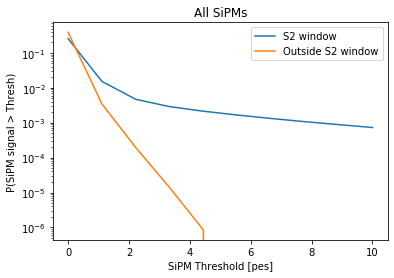

In [25]:
plt.plot(sipm_thresholds, prob_sipms_signal_s2, label='S2 window')
plt.plot(sipm_thresholds, prob_sipms_signal_outer, label='Outside S2 window')
plt.legend()
plt.yscale('log')
plt.xlabel('SiPM Threshold [pes]')
plt.ylabel('P(SiPM signal > Thresh)')
plt.title('All SiPMs')
plt.show()

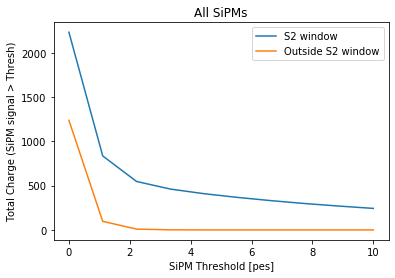

In [26]:
plt.plot(sipm_thresholds, total_charge_s2, label='S2 window')
plt.plot(sipm_thresholds, total_charge_outer, label='Outside S2 window')
plt.legend()
#plt.yscale('log')
plt.xlabel('SiPM Threshold [pes]')
plt.ylabel('Total Charge (SiPM signal > Thresh)')
plt.title('All SiPMs')
plt.show()

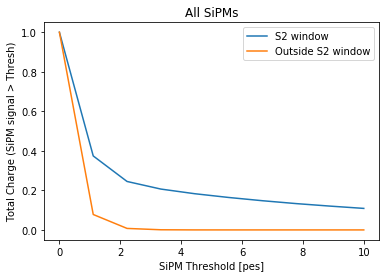

In [27]:
plt.plot(sipm_thresholds, total_charge_s2/total_charge_s2[0], label='S2 window')
plt.plot(sipm_thresholds, total_charge_outer/total_charge_outer[0], label='Outside S2 window')
plt.legend()
#plt.yscale('log')
plt.xlabel('SiPM Threshold [pes]')
plt.ylabel('Total Charge (SiPM signal > Thresh)')
plt.title('All SiPMs')
plt.show()

In [28]:
total_charge_outer

[1237.019305548057,
 96.51540922092259,
 9.37419824226296,
 0.9289006580825687,
 0.07073897364153608,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

#### Adding S2 threshold

In [29]:
# Remake when rerunning these boxes
sipms_s2 = calibrated_sipms[:,:,s2_window[0]:s2_window[1]]
sipms_outer = calibrated_sipms[:,:,outer_window[0]:outer_window[1]]

In [30]:
# Calculating probability of a sipm having over a signal for given thresholds
sipm_thresholds = np.linspace(0,10, 10)
sipm_thresholds_s2 = np.arange(0, 20, 2)
prob_sipms_signal_s2 = [np.mean(sipms_s2 > thresh) for thresh in sipm_thresholds]
prob_sipms_signal_outer = [np.mean(sipms_outer > thresh) for thresh in sipm_thresholds]

# Total charge in sipms over a given threshold
total_charge_s2 = []
total_charge_outer = []
for thresh in sipm_thresholds:
    copy_sipms_s2 = sipms_s2.copy()
    print('Charge lost = '+str(np.sum(copy_sipms_s2[copy_sipms_s2<thresh])))
    copy_sipms_s2[copy_sipms_s2<thresh] = 0
    int_sipms_s2 = np.sum(copy_sipms_s2, axis=2)
    
    copy_sipms_outer = sipms_outer.copy()
    copy_sipms_outer[copy_sipms_outer<thresh] = 0
    int_sipms_outer = np.sum(copy_sipms_outer, axis=2)
    
    this_charge_s2 = []
    this_charge_outer = []
    for thresh_s2 in sipm_thresholds_s2:
        int_sipms_s2[int_sipms_s2 < thresh_s2] = 0
        int_sipms_outer[int_sipms_outer < thresh_s2] = 0
        
        this_charge_s2.append(np.mean(np.sum(int_sipms_s2, axis=1)))
        this_charge_outer.append(np.mean(np.sum(int_sipms_outer, axis=1)))
        
    total_charge_s2.append(this_charge_s2)
    total_charge_outer.append(this_charge_outer)

Charge lost = 0.0
Charge lost = 731254.6735260525
Charge lost = 864320.0658734308
Charge lost = 903946.5700331493
Charge lost = 928148.7833507427
Charge lost = 947644.4410613629
Charge lost = 964637.1853360123
Charge lost = 979672.4730628765
Charge lost = 992733.7216579309
Charge lost = 1004706.6944367443


In [31]:
np.shape(total_charge_s2)

(10, 10)

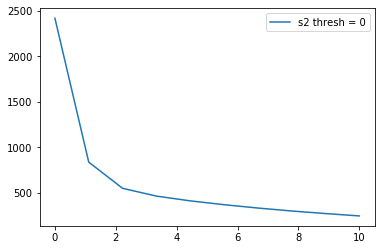

In [32]:
total_charge_s2 = np.array(total_charge_s2)
plt.plot(sipm_thresholds, total_charge_s2[:,0], label='s2 thresh = '+str(sipm_thresholds_s2[0]))
plt.legend()
#plt.yscale('log')
plt.show()

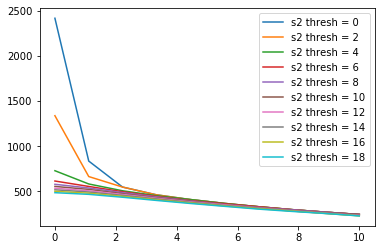

In [33]:
total_charge_s2 = np.array(total_charge_s2)
for i in range(len(sipm_thresholds_s2)):
    plt.plot(sipm_thresholds, total_charge_s2[:,i], label='s2 thresh = '+str(sipm_thresholds_s2[i]))
plt.legend()
#plt.yscale('log')
plt.show()

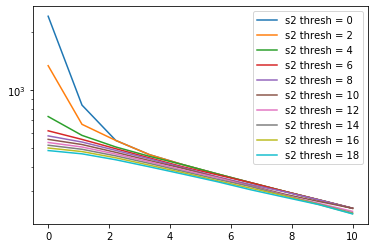

In [34]:
total_charge_s2 = np.array(total_charge_s2)
for i in range(len(sipm_thresholds_s2)):
    plt.plot(sipm_thresholds, total_charge_s2[:,i], label='s2 thresh = '+str(sipm_thresholds_s2[i]))
plt.legend()
plt.yscale('log')
plt.show()

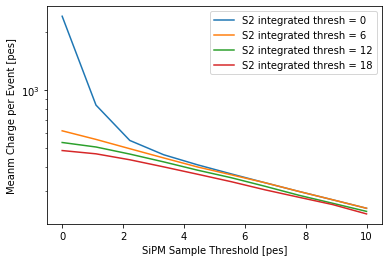

In [35]:
total_charge_s2 = np.array(total_charge_s2)
for i in [0,3,6,9]: #range(len(sipm_thresholds_s2)):
    plt.plot(sipm_thresholds, total_charge_s2[:,i], label='S2 integrated thresh = '+str(sipm_thresholds_s2[i]))
plt.legend()
plt.yscale('log')
plt.xlabel('SiPM Sample Threshold [pes]')
plt.ylabel('Meanm Charge per Event [pes]')
plt.show()

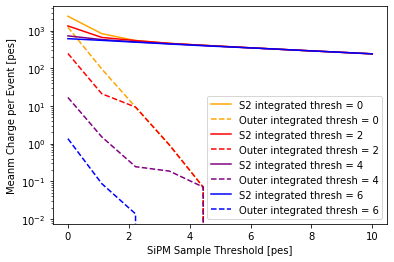

In [70]:
total_charge_outer = np.array(total_charge_outer)
colors = ['orange', 'red', 'purple', 'blue', 'green', 'black']
j = 0
for i in [0,1,2,3]: #range(len(sipm_thresholds_s2)):
    plt.plot(sipm_thresholds, total_charge_s2[:,i], label='S2 integrated thresh = '+str(sipm_thresholds_s2[i]), color=colors[j])
    plt.plot(sipm_thresholds, total_charge_outer[:,i], label='Outer integrated thresh = '+str(sipm_thresholds_s2[i]), linestyle='dashed', color=colors[j])
    j += 1
plt.legend()
plt.yscale('log')
plt.xlabel('SiPM Sample Threshold [pes]')
plt.ylabel('Meanm Charge per Event [pes]')
plt.show()

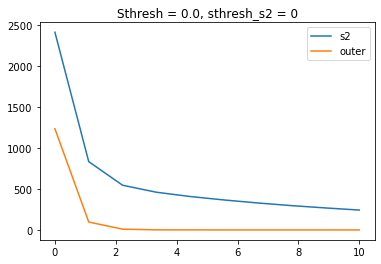

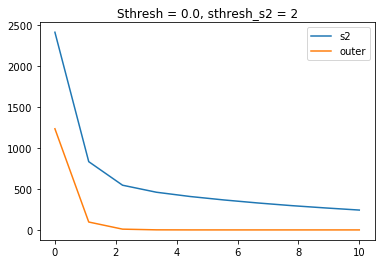

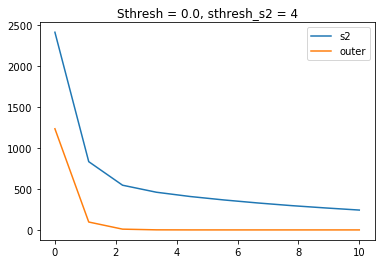

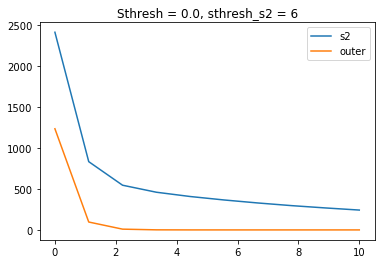

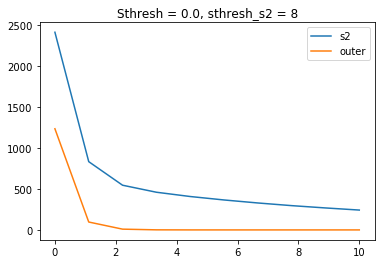

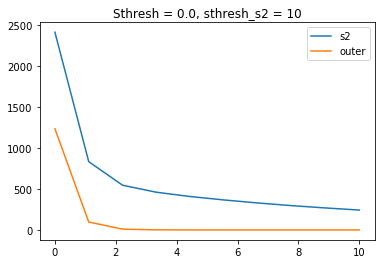

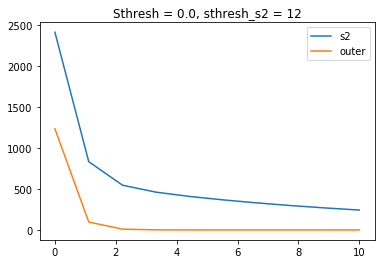

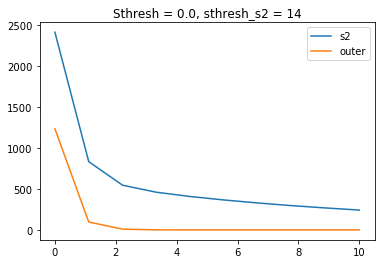

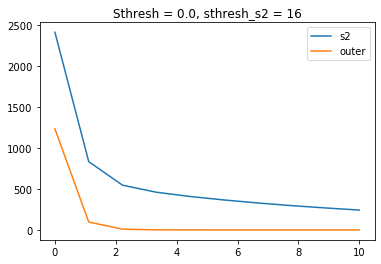

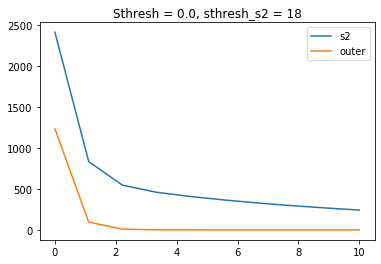

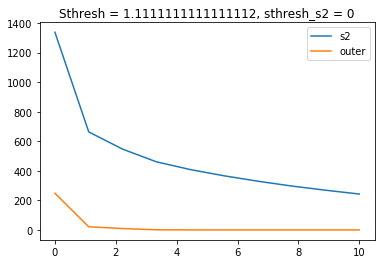

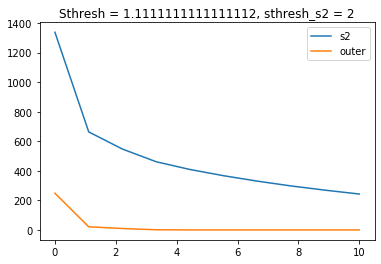

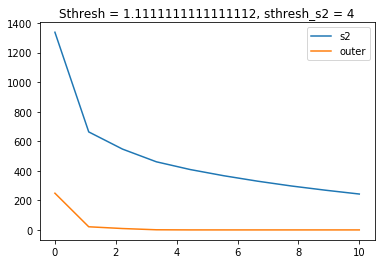

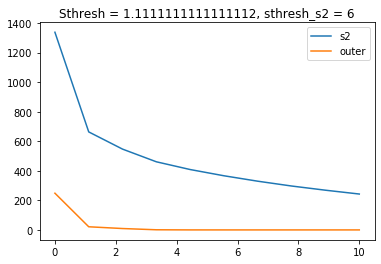

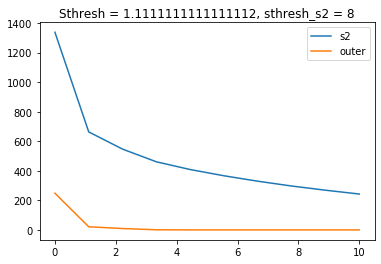

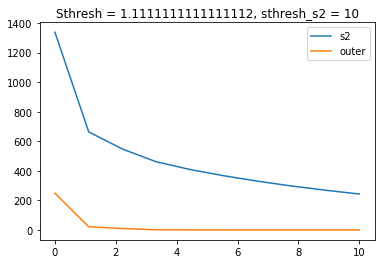

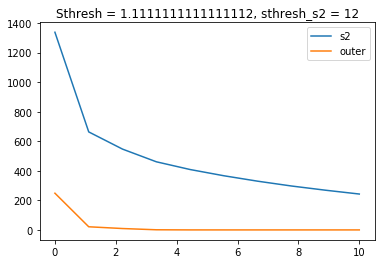

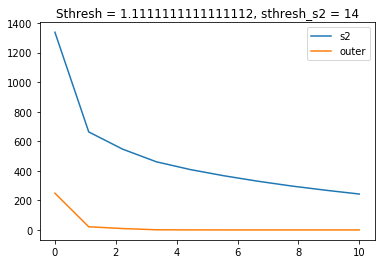

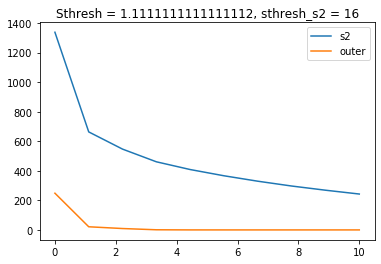

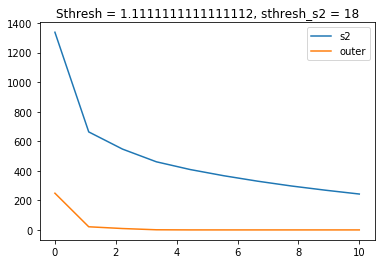

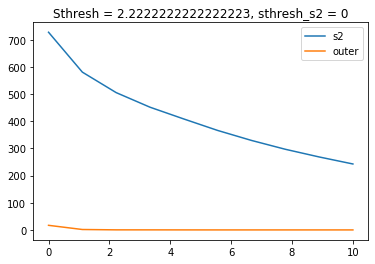

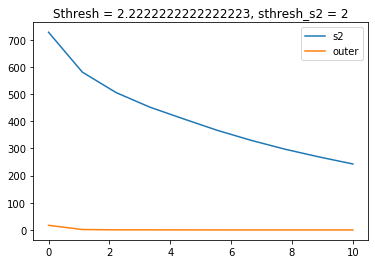

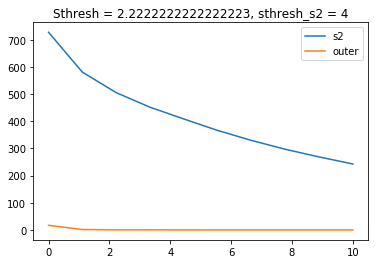

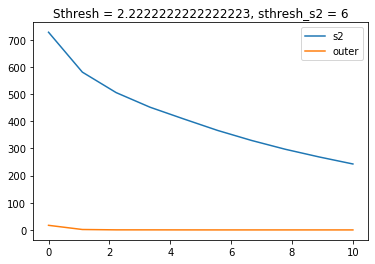

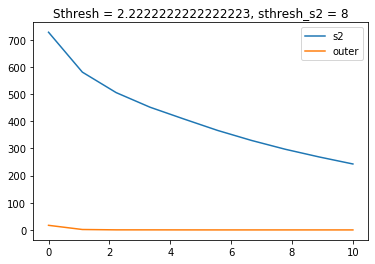

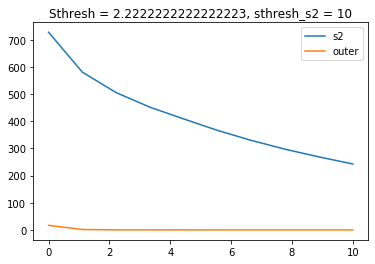

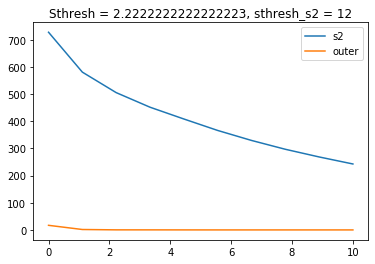

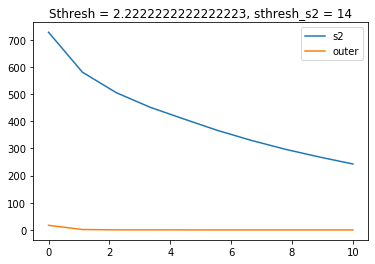

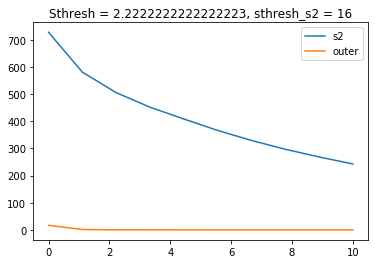

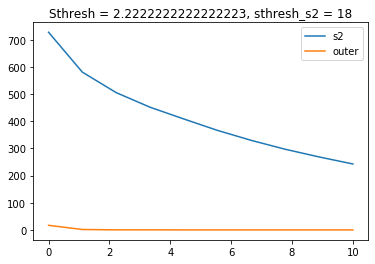

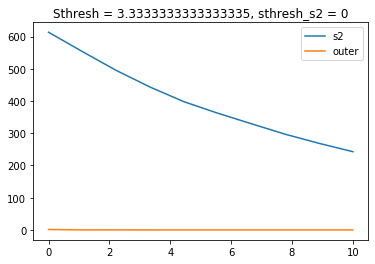

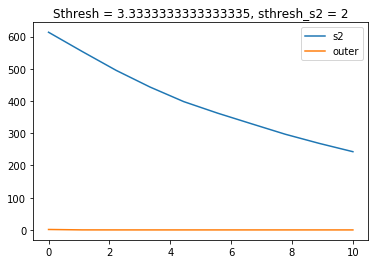

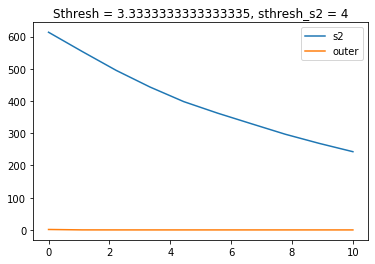

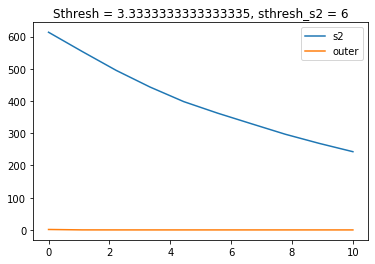

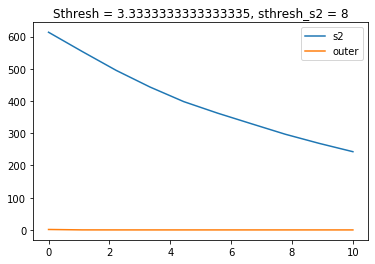

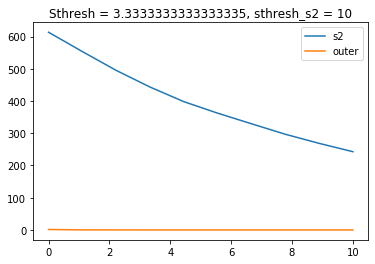

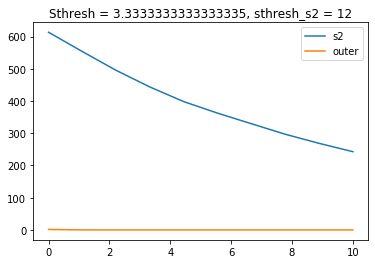

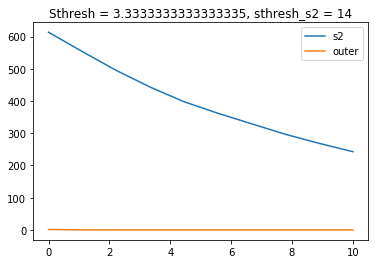

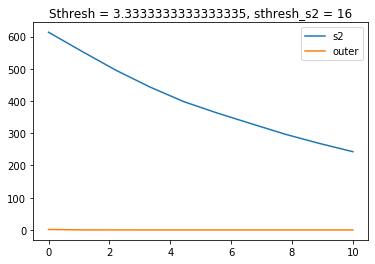

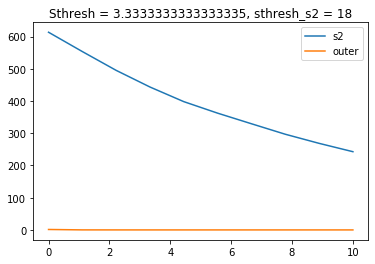

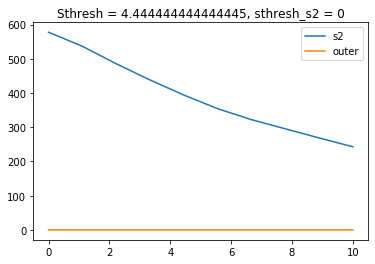

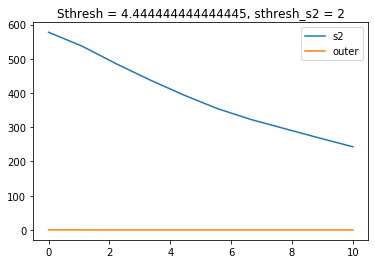

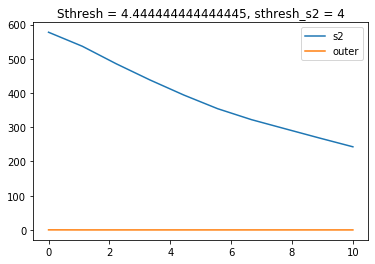

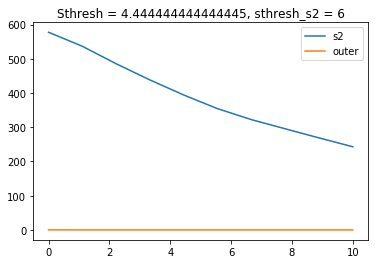

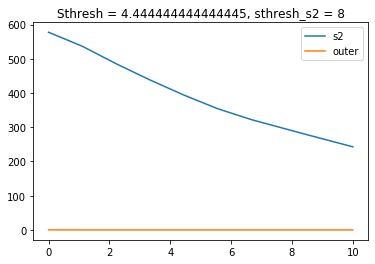

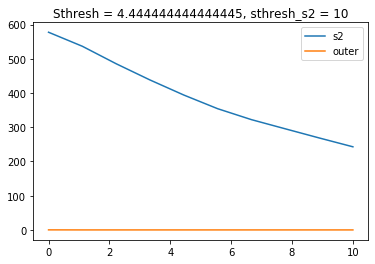

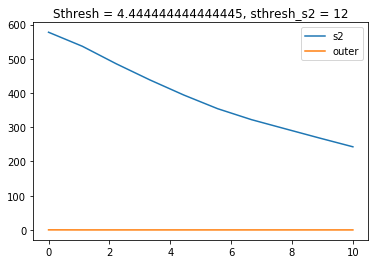

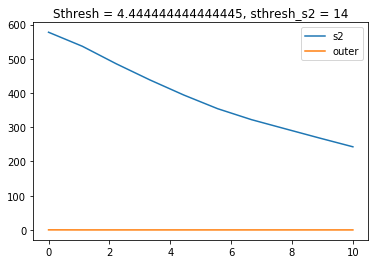

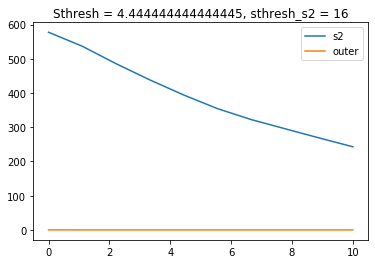

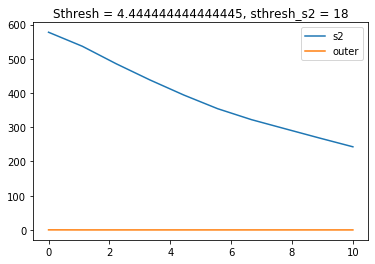

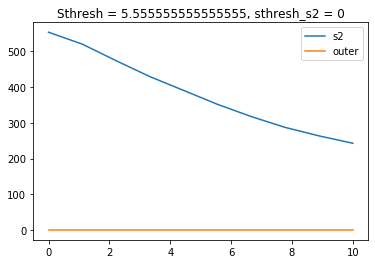

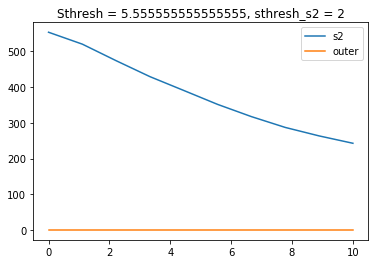

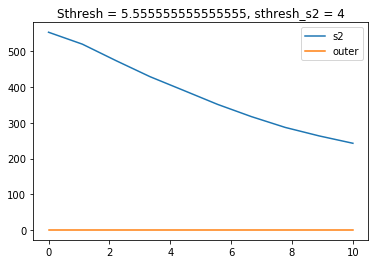

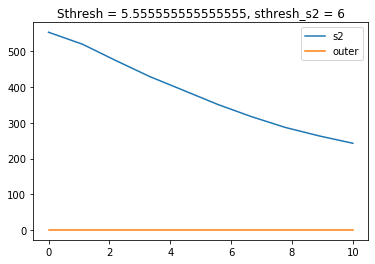

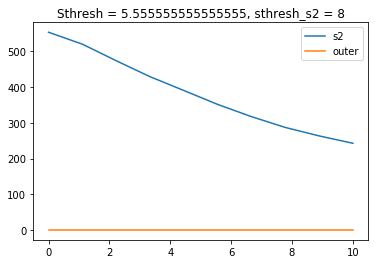

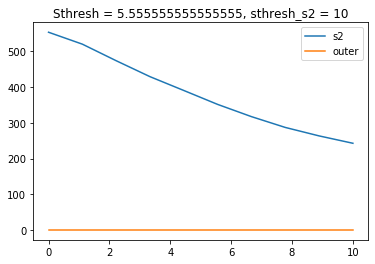

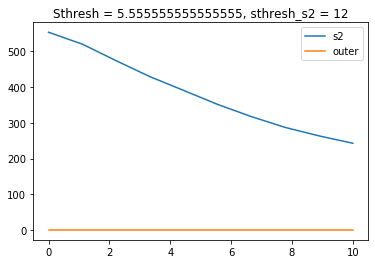

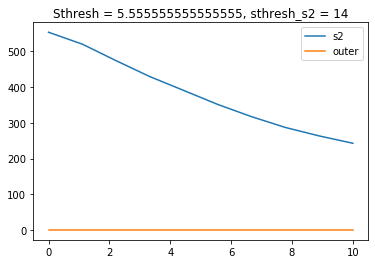

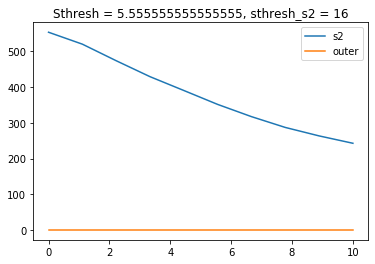

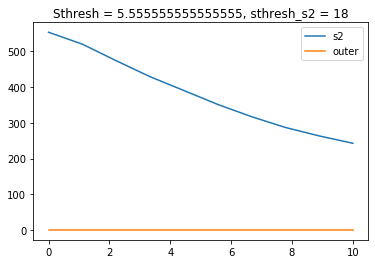

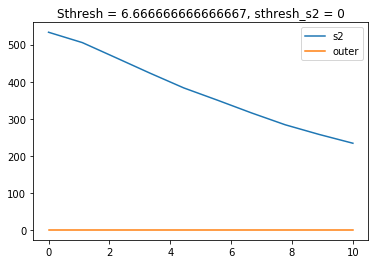

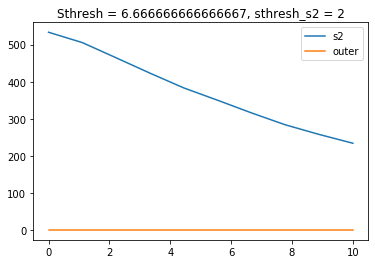

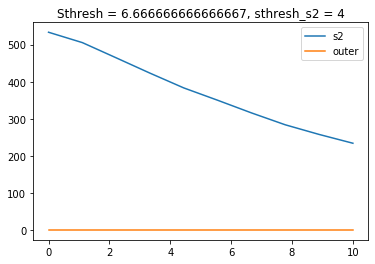

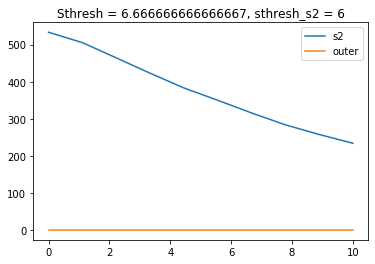

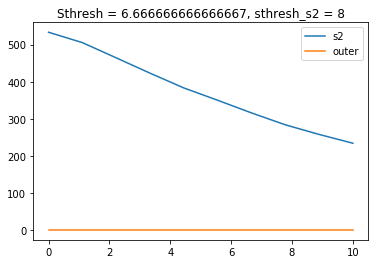

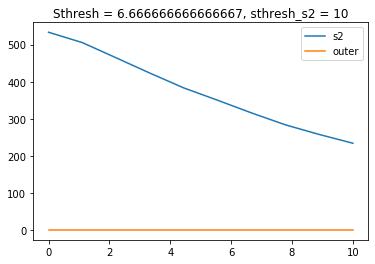

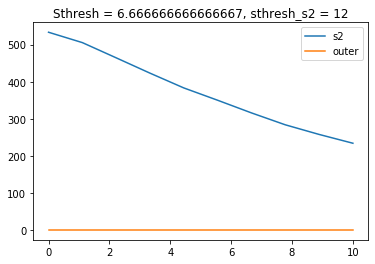

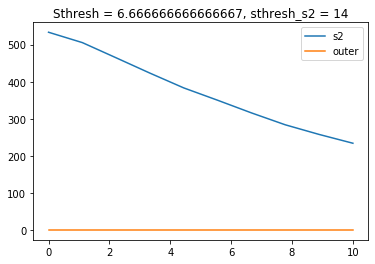

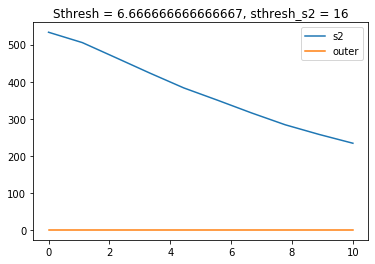

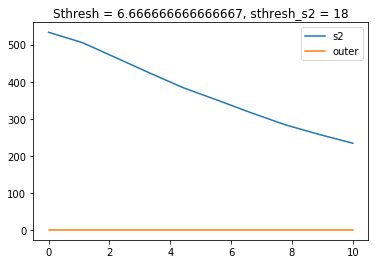

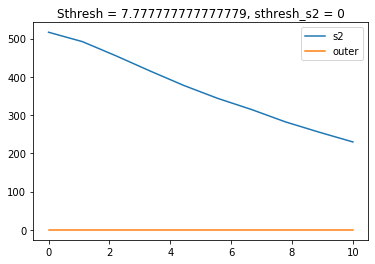

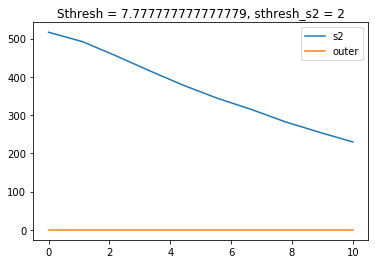

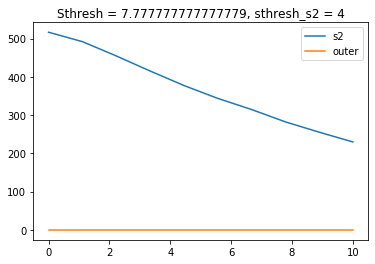

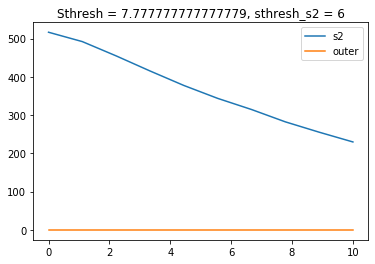

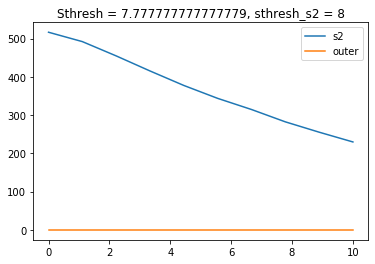

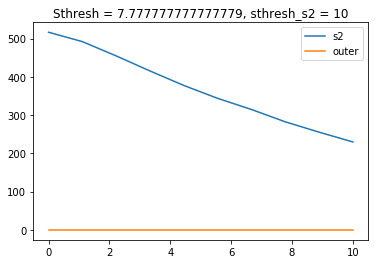

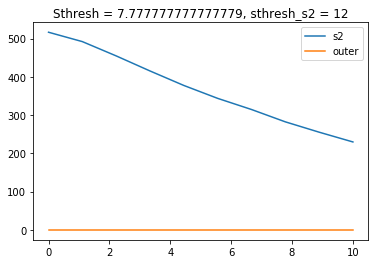

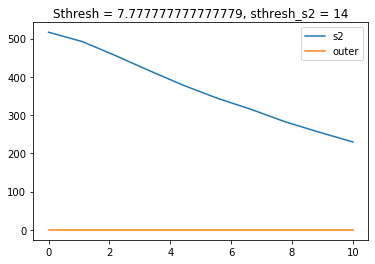

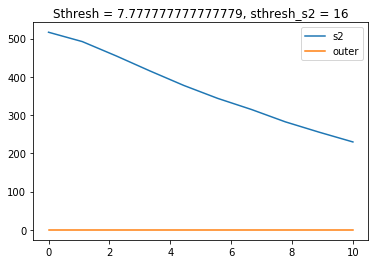

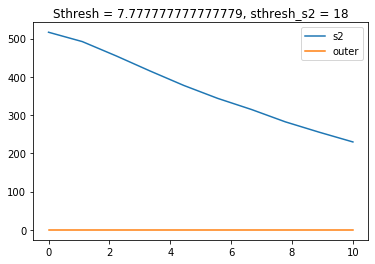

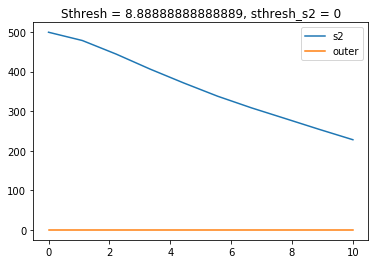

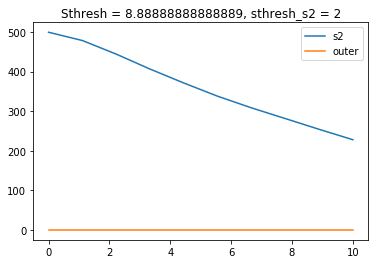

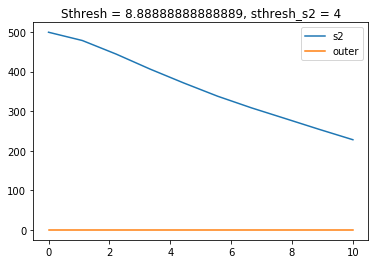

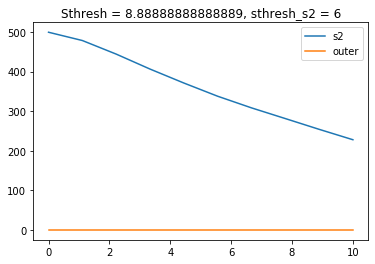

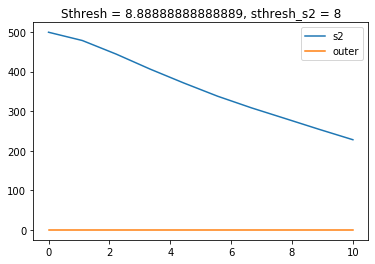

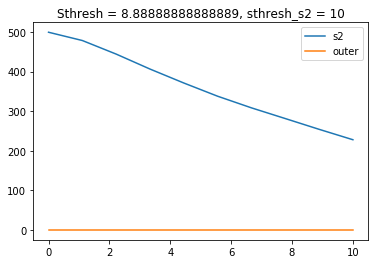

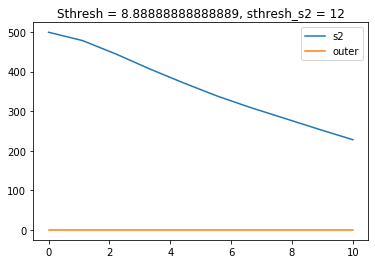

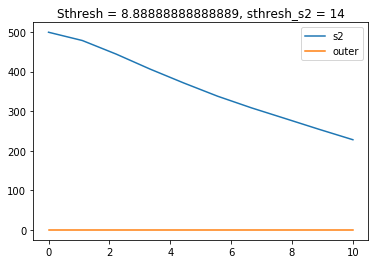

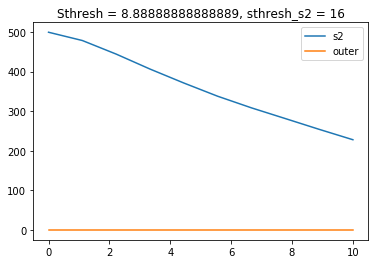

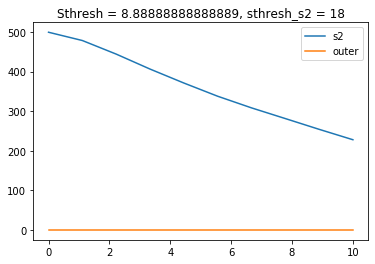

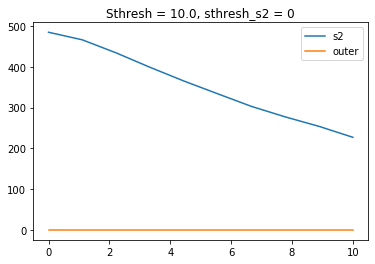

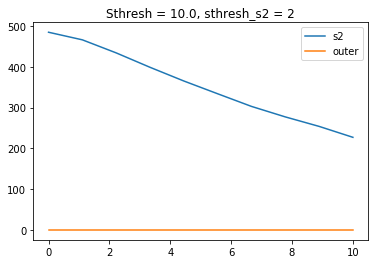

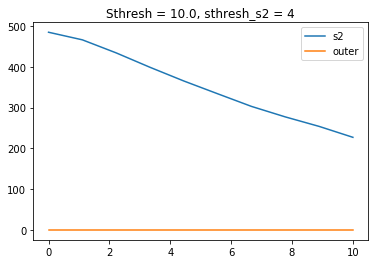

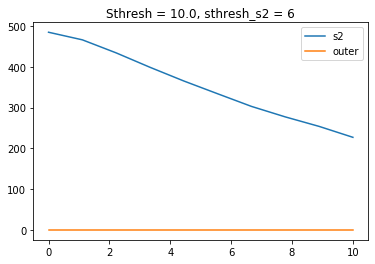

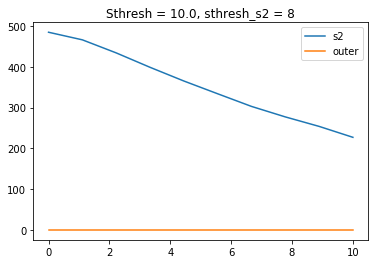

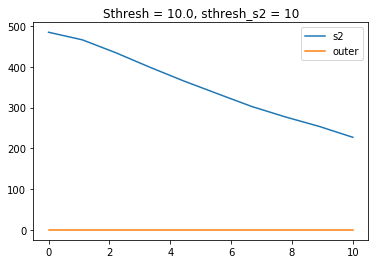

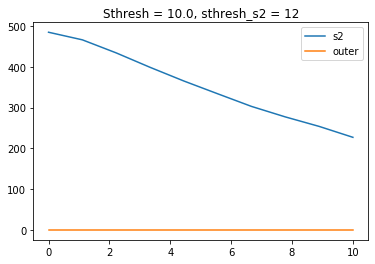

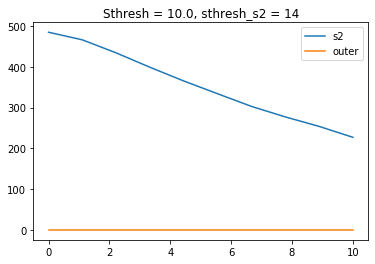

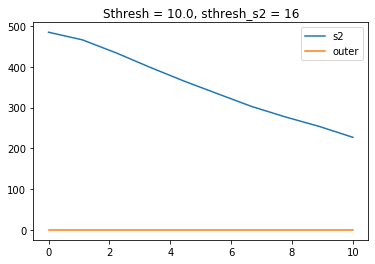

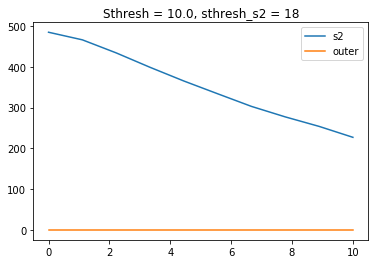

In [34]:
total_charge_s2 = np.array(total_charge_s2)
total_charge_outer = np.array(total_charge_outer)
for sthresh in range(len(sipm_thresholds)):
    for sthresh_s2 in range(len(sipm_thresholds)):
        plt.plot(sipm_thresholds, total_charge_s2[:,sthresh], label='s2')
        plt.plot(sipm_thresholds, total_charge_outer[:,sthresh], label='outer')
        plt.legend()
        plt.title('Sthresh = '+str(sipm_thresholds[sthresh])+', sthresh_s2 = '+str(sipm_thresholds_s2[sthresh_s2]))
        plt.show()

### Whats the probability of having a signal higher than some threshold in a r cut around the max sipm? 

In [49]:
# Get SiPM position information
dbfile = 'new'
datasipm   = load_db.DataSiPM(dbfile, run_number)
sipm_xs    = datasipm.X.values
sipm_ys    = datasipm.Y.values
sipm_xys   = np.stack((sipm_xs, sipm_ys), axis=1)
sipm_xys = np.delete(sipm_xys, worst_sipms, axis=0) # remove bad sipms
np.shape(sipm_xys)

(1790, 2)

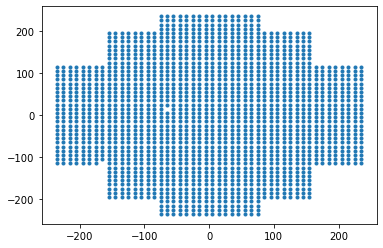

In [50]:
# Plot sipm positions
plt.plot(sipm_xys[:,0], sipm_xys[:,1], '.')

In [51]:
# Testing out finding sipms with a radius of the max sipm
max_sipm_r_cut = 10.
t = 800
event = 0
event_charge = calibrated_sipms[event,:,t]
max_sipm = np.argmax(event_charge)
within_lm_radius  = xya.get_nearby_sipm_inds(sipm_xys[max_sipm], max_sipm_r_cut, sipm_xys)
new_local_maximum = xya.barycenter(sipm_xys[within_lm_radius], event_charge[within_lm_radius])[0].posxy

In [52]:
sipm_xys[max_sipm][0]

75.0

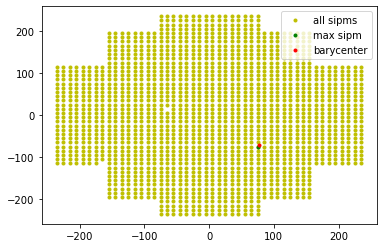

In [53]:
# Plot sipm positions
plt.plot(sipm_xys[:,0], sipm_xys[:,1], '.', color='y', label='all sipms')
plt.plot(sipm_xys[max_sipm][0], sipm_xys[max_sipm][1], '.', color='g', label='max sipm')
plt.plot(new_local_maximum[0,0], new_local_maximum[0,1],'.', color='r', label='barycenter')
plt.legend()

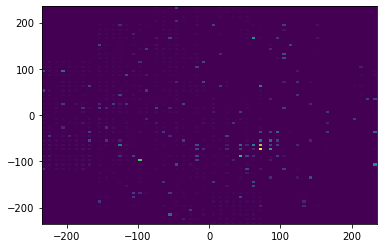

In [54]:
plt.hist2d(sipm_xys[:,0], sipm_xys[:,1], weights=event_charge, bins=100)
plt.show()

In [34]:
# likelihood that sipms with that radius have above threshold energy
thresh = 2.0
(event_charge[within_lm_radius] > thresh).mean()

0.6

In [35]:
sipms_s2 = calibrated_sipms[:,:,s2_window[0]:s2_window[1]]
max_sipms = np.argmax(sipms_s2, axis=1)
max_sipm_charges = np.max(sipms_s2, axis=1)
np.shape(max_sipms)

(462, 10)

In [36]:
sipms_outer = calibrated_sipms[:,:,outer_window[0]:outer_window[1]]
max_sipms_outer = np.argmax(sipms_outer, axis=1)
max_sipm_charges_outer = np.max(sipms_outer, axis=1)
np.shape(max_sipms_outer)

(462, 10)

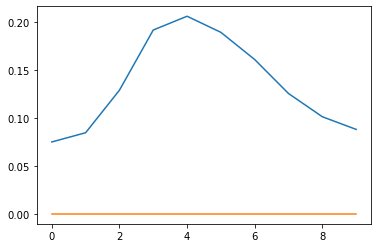

In [37]:
plt.plot(np.mean(np.mean(sipms_s2, axis=1), axis=0))
plt.plot(np.mean(np.mean(sipms_outer, axis=1), axis=0))

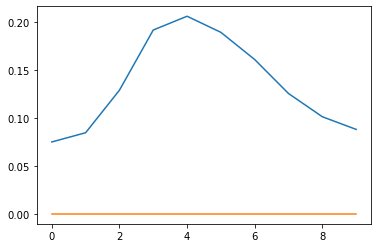

In [38]:
plt.plot(np.mean(np.mean(calibrated_sipms[:,:,s2_window[0]:s2_window[1]], axis=1), axis=0))
plt.plot(np.mean(np.mean(calibrated_sipms[:,:,outer_window[0]:outer_window[1]], axis=1), axis=0))

In [39]:
sipms_outer = np.zeros(np.shape(sipms_outer))

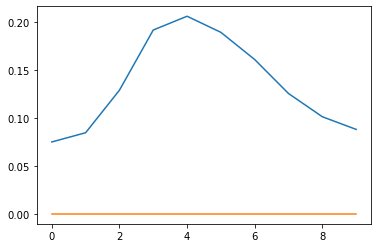

In [40]:
plt.plot(np.mean(np.mean(sipms_s2, axis=1), axis=0))
plt.plot(np.mean(np.mean(sipms_outer, axis=1), axis=0))

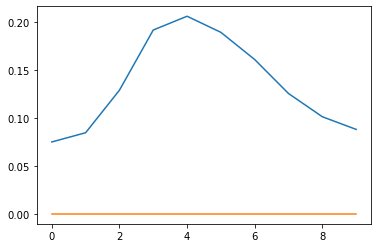

In [41]:
plt.plot(np.mean(np.mean(calibrated_sipms[:,:,s2_window[0]:s2_window[1]], axis=1), axis=0))
plt.plot(np.mean(np.mean(calibrated_sipms[:,:,outer_window[0]:outer_window[1]], axis=1), axis=0))

In [42]:
np.shape(sipms_s2)

(462, 1790, 10)

In [43]:
np.shape(sipms_s2)

(462, 1790, 10)

In [44]:
np.shape(sipm_xys[max_sipms])

(462, 10, 2)

In [45]:
def ProbAboveThreshBary(max_sipm_r_cut):
    prob_above_thresh_maxsipm_s2 = []
    prob_above_thresh_maxsipm_outer = []
    for thresh in sipm_thresholds:
        above_thresh_mean = []
        for event in range(len(sipms_s2)):
            for t in range(len(sipms_s2[event,0,:])):
                within_lm_radius  = xya.get_nearby_sipm_inds(sipm_xys[max_sipms[event,t]], max_sipm_r_cut, sipm_xys)
                these_sipms = sipms_s2[event,within_lm_radius,t]
                above_thresh_mean.append((these_sipms > thresh).mean())
        prob_above_thresh_maxsipm_s2.append(np.mean(above_thresh_mean))

        above_thresh_mean = []
        for event in range(len(sipms_outer)):
            for t in range(len(sipms_outer[event,0,:])):
                within_lm_radius  = xya.get_nearby_sipm_inds(sipm_xys[max_sipms[event,t]], max_sipm_r_cut, sipm_xys)
                these_sipms = sipms_outer[event,within_lm_radius,t]
                above_thresh_mean.append((these_sipms > thresh).mean())
        prob_above_thresh_maxsipm_outer.append(np.mean(above_thresh_mean))
    return prob_above_thresh_maxsipm_s2, prob_above_thresh_maxsipm_outer

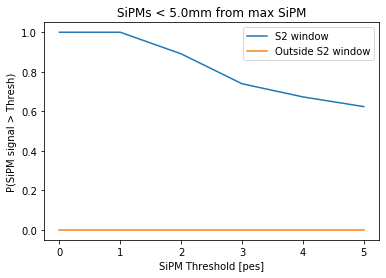

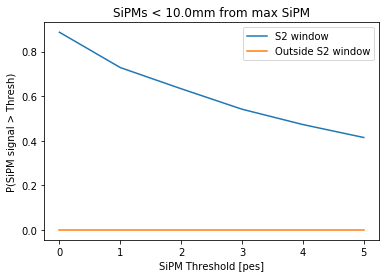

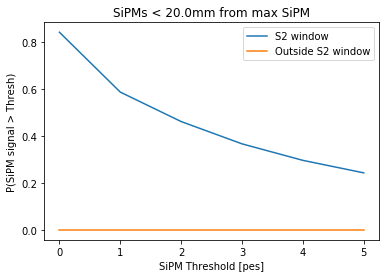

In [46]:
sipm_thresholds = np.linspace(0,5,6)
r_cuts = [5., 10., 20.]
for r in r_cuts:
    prob_above_thresh_maxsipm_s2, prob_above_thresh_maxsipm_outer = ProbAboveThreshBary(r)
    plt.plot(sipm_thresholds, prob_above_thresh_maxsipm_s2, label='S2 window')
    plt.plot(sipm_thresholds, prob_above_thresh_maxsipm_outer, label='Outside S2 window')
    plt.legend()
    #plt.yscale('log')
    plt.xlabel('SiPM Threshold [pes]')
    plt.ylabel('P(SiPM signal > Thresh)')
    plt.title('SiPMs < '+str(r)+'mm from max SiPM')
    plt.show()

# Cuts a function of R from central SiPM

In [47]:
m1 = np.argmax(np.sum(sipms_s2, axis=2), axis=1)
m2 = np.argmax(sipms_s2, axis=1)
np.shape(m1)

(462,)

In [48]:
np.shape(sipm_xys[m1[0]])

NameError: name 'sipm_xys' is not defined

In [49]:
np.max(np.argmax(np.sum(sipms_s2, axis=2), axis=1))

1747

In [57]:
max_sipms = np.argmax(sipms_s2, axis=1) #np.argmax(np.sum(sipms_s2, axis=2), axis=1)
max_sipms_outer = np.argmax(np.sum(sipms_outer, axis=2), axis=1)
thresh = 2
max_sipm_r_cut = 10
s2_rcut_data = []
outer_rcut_data = []
nevents = len(sipms_s2)
for event in range(nevents): 
    within_lm_radius = xya.get_nearby_sipm_inds(sipm_xys[max_sipms[event]], max_sipm_r_cut, sipm_xys)
    s2_rcut_data.append(np.sum(sipms_s2[event,within_lm_radius,:]))
    
    within_lm_radius = xya.get_nearby_sipm_inds(sipm_xys[max_sipms_outer[event]], max_sipm_r_cut, sipm_xys)
    outer_rcut_data.append(np.sum(sipms_outer[event,within_lm_radius,:]))

ValueError: operands could not be broadcast together with shapes (1790,2) (10,2) 

In [ ]:
hist_range = (0,700)
bins = 100
plt.hist(s2_rcut_data, range=hist_range, bins=bins, label='S2 Window')
plt.hist(outer_rcut_data, range=hist_range, bins=bins, label='Outer Window')
plt.xlabel('Total Charge [pes]')
plt.title(f'd < {max_sipm_r_cut}mm, SiPM > {thresh}')
plt.legend()
plt.show()

In [ ]:
thresh = 0
ds = np.arange(0,300,10) #[5.0, 10.0, 15.0, 20.0, 30, 50, 100]
mean_by_d_s2 = []
sigma_by_d_s2 = []
mean_by_d_outer = []
sigma_by_d_outer = []
eres_by_d = []
eres_errs = []
eres_qbb_by_d = []
for d in ds:
    s2_rcut_data = []
    outer_rcut_data = []
    nevents = len(sipms_s2)
    for event in range(nevents): 
        within_lm_radius = xya.get_nearby_sipm_inds(sipm_xys[max_sipms[event]], d, sipm_xys)
        s2_rcut_data.append(np.sum(sipms_s2[event,within_lm_radius,:]))
    
        within_lm_radius = xya.get_nearby_sipm_inds(sipm_xys[max_sipms_outer[event]], d, sipm_xys)
        outer_rcut_data.append(np.sum(sipms_outer[event,within_lm_radius,:]))
        
    fe = fit_energy(np.array(s2_rcut_data), 100, (np.min(s2_rcut_data), np.max(s2_rcut_data)))
    eres, err, eres_qbb, sigma, mean = eres_err(fe)
    eres_by_d.append(eres)
    eres_errs.append(err)
    eres_qbb_by_d.append(eres_qbb)
    mean_by_d_s2.append(mean)
    sigma_by_d_s2.append(sigma)

    mean_by_d_outer.append(np.mean(outer_rcut_data))
    sigma_by_d_outer.append(np.std(outer_rcut_data))

In [ ]:
plt.plot(ds, eres_by_d, marker='')
plt.xlabel('d [mm]')
plt.ylabel('Eres FWHM % (41.5 keV)')
plt.title('Signal from SiPMs < d from central SiPM, SiPM Charge > '+str(thresh))
plt.show()

plt.plot(ds, mean_by_d_s2, marker='', label='S2 window')
plt.plot(ds, mean_by_d_outer, marker='', label='Outer window')
plt.xlabel('d [mm]')
plt.ylabel('Mean Charge [pes]')
plt.title('Signal from SiPMs < d from central SiPM, SiPM Charge > '+str(thresh))
plt.legend()
plt.show()

plt.plot(ds, sigma_by_d_s2, marker='', label='S2 window')
plt.plot(ds, sigma_by_d_outer, marker='', label='Outer window')
plt.xlabel('d [mm]')
plt.ylabel('STD Charge [pes]')
plt.title('Signal from SiPMs < d from central SiPM, SiPM Charge > '+str(thresh))
plt.legend()
plt.show()

In [ ]:
np.shape(sipm_xys[:,0])

In [ ]:
calibrated_sum = np.sum(calibrated_sipms,axis=2)
event_sipms = calibrated_sum[0]

In [ ]:
events_summed = np.sum(calibrated_sum, axis=1)
xs = np.sum(sipm_xys[:,0]*calibrated_sum, axis=1) / events_summed
ys = np.sum(sipm_xys[:,0]*calibrated_sum, axis=1) / events_summed

In [ ]:
these_sipms_ind = np.where(calibrated_sipms > 1)
these_sipms_ind

In [ ]:
np.shape(these_sipms_ind)

In [ ]:
sipm_thresholds = [0] #,2,5]
for sthresh in sipm_thresholds:
    calibrated_sum = np.sum(calibrated_sipms,axis=2)
    event_sipms = calibrated_sum[0]

    events_summed = np.sum(calibrated_sum, axis=1)
    xs = np.sum(sipm_xys[:,0]*calibrated_sum, axis=1) / events_summed
    ys = np.sum(sipm_xys[:,0]*calibrated_sum, axis=1) / events_summed

    plt.hist(xs, bins=50)
    plt.show()

    plt.hist(ys, bins=50)
    plt.show()

In [ ]:
plt.hist(sipm_xys[max_sipms][:,0], bins=20)
plt.show()

plt.hist(sipm_xys[max_sipms][:,1], bins=20)
plt.show()

In [ ]:
plt.hist(np.sqrt(sipm_xys[max_sipms][:,0]**2 + sipm_xys[max_sipms][:,1]**2))

In [59]:
rs = np.sqrt(sipm_xys[max_sipms][:,0]**2 + sipm_xys[max_sipms][:,1]**2)
calibrated_rcut_sipms = calibrated_sipms[np.argwhere(rs > 100)]

In [ ]:
np.shape(np.argwhere(rs > 150)[:,0])

In [ ]:
this = calibrated_sipms[np.argwhere(rs > 150)[:,0],:,:]
np.shape(this)

In [ ]:
np.shape(sipms_s2)

In [ ]:
x = np.sum(sipmtable_df.charge*sipmtable_df.X)/np.sum(sipmtable_df.charge)
y = np.sum(sipmtable_df.charge*sipmtable_df.Y)/np.sum(sipmtable_df.charge)
charge = np.sum(sipmtable_df.charge)

r = np.sqrt(x**2 + y**2)

In [ ]:
sipm_indices = 
sipm_xys[max_sipms[event]], dˇ, sipm_xys)

In [ ]:
sipm_xys[xya.get_nearby_sipm_inds([5.,-105], max_sipm_r_cut, sipm_xys)]

In [ ]:
xya.get_nearby_sipm_inds(sipm_xys[max_sipms[event,t]], max_sipm_r_cut, sipm_xys)

In [ ]:
sipm_xys[1]

### Energy Resolution

In [ ]:
# Get sum in S2 window
np.shape(sipms_s2) # events, sipms, time bins

In [ ]:
s2_sum = np.sum(np.sum(sipms_s2, axis=2), axis=1)
np.shape(s2_sum)

In [ ]:
plt.hist(s2_sum, bins=50)
plt.xlabel('Total Tracking Plane Charge per Event [pes]')
plt.show()

#### Zero Suppressed SiPMs

In [ ]:
thresh = 5
sipms_s2_sum = np.sum(sipms_s2, axis=2)
z_sipms_s2 = sipms_s2_sum
cut_charge = z_sipms_s2[z_sipms_s2<= thresh]
z_sipms_s2[z_sipms_s2 <= thresh] = 0
shape = np.shape(sipms_s2_sum)
z_sipms_s2 = np.reshape(z_sipms_s2, shape)
z_s2_sum = np.sum(z_sipms_s2, axis=1)

In [ ]:
plt.hist(z_s2_sum, bins=50, label="SiPM Threshold = "+str(thresh))
plt.hist(s2_sum, bins=50, label="SiPM Threshold = 0")
#plt.title('Zero Suppressed')
plt.xlabel('Total Tracking Plane Charge per Event [pes]')
plt.legend()
plt.show()

#### ICAROS Eres functions

In [51]:
from dataclasses import dataclass
from typing      import Tuple
from typing      import TypeVar
from typing      import Callable
from collections import namedtuple
from scipy.optimize          import OptimizeWarning
import warnings

from invisible_cities.core.core_functions  import shift_to_bin_centers
from invisible_cities.core                 import fit_functions as fitf
from invisible_cities.evm  .ic_containers import FitFunction
from   invisible_cities.core.core_functions    import in_range
from   invisible_cities.core .stat_functions import poisson_sigma
from matplotlib.ticker import AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

Measurement = namedtuple('Measurement', 'value uncertainty')
Number = TypeVar('Number', None, int, float)
NN = np.nan

@dataclass
class HistoPar:
    var    : np.array
    nbins  : int
    range  : Tuple[float]
        
@dataclass
class GaussPar:
    mu    : Measurement
    std   : Measurement
    amp   : Measurement
        
@dataclass
class ProfilePar:
    x  : np.array
    y  : np.array
    xu : np.array
    yu : np.array
        
@dataclass
class FitPar(ProfilePar):
    f     : FitFunction
        
@dataclass
class FitResult:
    par   : np.array
    err   : np.array
    chi2  : float
    valid : bool
        
@dataclass
class FitCollection:
    fp   : FitPar
    hp   : HistoPar
    fr   : FitResult
        
def gaussian_parameters(x : np.array, range : Tuple[Number], bin_size : float = 1)->GaussPar:
    """
    Return the parameters defining a Gaussian
    g = N * exp(x - mu)**2 / (2 * std**2)
    where N is the normalization: N = 1 / (sqrt(2 * np.pi) * std)
    The parameters returned are the mean (mu), standard deviation (std)
    and the amplitude (inverse of N).
    """
    mu, std = mean_and_std(x, range)
    ff     = np.sqrt(2 * np.pi) * std

    amp     = len(x) * bin_size / ff

    sel  = in_range(x, *range)
    N = len(x[sel])              # number of samples in range
    mu_u  = std / np.sqrt(N)
    std_u = std / np.sqrt(2 * (N -1))
    amp_u = np.sqrt(2 * np.pi) * std_u

    return GaussPar(mu  = Measurement(mu, mu_u),
                    std = Measurement(std, std_u),
                    amp = Measurement(amp, amp_u))

def gaussian_fit(x       : np.array,
                 y       : np.array,
                 seed    : GaussPar,
                 n_sigma : int)  ->Tuple[FitPar, FitResult]:
    """Gaussian fit to x,y variables, with fit range defined by n_sigma"""

    mu  = seed.mu.value
    std = seed.std.value
    amp = seed.amp.value
    fit_range = mu - n_sigma * std, mu + n_sigma * std

    x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
    yu        = poisson_sigma(y)
    fseed     = (amp, mu, std)

    par, err = par_and_err_from_seed(seed)
    fr = FitResult(par = par,
                   err = err,
                   chi2 = NN,
                   valid = False)
    fp = None

    with warnings.catch_warnings():
        warnings.filterwarnings('error')  # in order to handle fit failures here
        try:
            fp, fr = gfit(x, y, yu, fseed)
        except RuntimeWarning:   # this is the most usual failure, and usually solved trying fitx
                                 # with a different seed
            print(f' fit failed for seed  = {seed}, due to RunTimeWarning, retry fit ')
            fseed = (10*fseed[0], fseed[1], fseed[2] )
            try:
                fp, fr = gfit(x, y, yu, fseed)
            except RuntimeWarning: #  Give up on second failure
                print(f' fit failed for seed  = {seed}, due to RunTimeWarning, give up ')
        except OptimizeWarning:
            print(f' OptimizeWarning was raised for seed  = {seed} due to OptimizeWarning')
        except RuntimeError:
            print(f' fit failed for seed  = {seed}  due to RunTimeError')
        except TypeError:
            print(f' fit failed for seed  = {seed}  due to TypeError')

    return fp, fr

def fit_energy(e : np.array,
               nbins   : int,
               range   : Tuple[float],
               n_sigma : float = 3.0)->FitCollection:
    """
    Takes an "energy vector" (e.g, 1d array), with number of bins enbins and range erange, then:
        1. Computes the histogram of e with enbins in erange. This returns an array of bin
        edges (b), and bin contents (y). The array (b) is shifted to bin centers (x)
        2. The arrays x and y are fitted to a gaussian, in a range given by an interval
        arround the estimation of the maximum of the gaussian. The interval size is estimated
        by multiplying n_sigma by the estimation of the gaussian std.
    The result of the fit is a fit collection, that includes a FitPar and a HistoPar objects
    needed for printing and plotting the fit result.
       """

    y, b = np.histogram(e, bins= nbins, range=range)
    x = shift_to_bin_centers(b)
    bin_size = (range[1] - range[0]) / nbins
    seed = gaussian_parameters(e, range, bin_size)

    fp, fr = gaussian_fit(x, y, seed, n_sigma)

    hp = HistoPar(var      = e,
                  nbins    = nbins,
                  range    = range)

    return FitCollection(fp = fp, hp = hp, fr = fr)

def mean_and_std(x : np.array, range_ : Tuple[Number, Number])->Tuple[Number, Number]:
    """Computes mean and std for an array within a range: takes into account nans"""

    mu  = NN
    std = NN

    if all(np.isnan(x)):  # all elements are nan
        mu  = NN
        std = NN
    else:
        x_nonnan = x[np.isfinite(x)]
        y = x_nonnan[in_range(x_nonnan, *range_)]
        if len(y) == 0:
            warnings.warn(f'warning, empty slice of x = {x} in range = {range_}')
            mu  = NN
            std = NN
        else:
            mu  = np.mean(y)
            std = np.std(y)

    return mu, std

def par_and_err_from_seed(seed : GaussPar) ->Tuple[np.array, np.array]:
    par = np.zeros(3)
    err = np.zeros(3)
    par[0] = seed.amp.value
    par[1] = seed.mu.value
    par[2] = seed.std.value
    err[0] = seed.amp.uncertainty
    err[1] = seed.mu.uncertainty
    err[2] = seed.std.uncertainty
    return par, err

def gfit(x     : np.array,
         y     : np.array,
         yu    : np.array,
         fseed : Tuple[float, float, float]) ->Tuple[FitPar, FitResult]:

    f     = fitf.fit(fitf.gauss, x, y, fseed, sigma=yu)
    c2    = chi2(f, x, y, yu)
    par  = np.array(f.values)
    err  = np.array(f.errors)
    xu   = np.diff(x) * 0.5

    fr = FitResult(par = par,
                   err = err,
                   chi2 = c2,
                   valid = True)
    fp = FitPar(x  = x, y  = y, xu = xu, yu = yu, f  = f.fn)

    return fp, fr

def chi2f(f   : Callable,
          nfp : int,        # number of function parameters
          x   : np.array,
          y   : np.array,
          yu  : np.array)->float:
    """
    Computes the chi2 of a function f applied over array x and compared
    with array y with error yu
    """

    assert len(x) == len(y) == len(yu)
    fitx  = f(x)
    chi2_ = np.sum(((y - fitx) / yu)**2)

    if len(x) > nfp:
        return chi2_/(len(x)-nfp)
    else:
        warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
        return chi2_


def chi2(f : FitFunction,
         x : np.array,
         y : np.array,
         sy: np.array)->float:
    """
    Computes the chi2 of a function f applied over array x and compared
    with array y with error yu. The object f is of type FitFunction.
    """
    return chi2f(f.fn, len(f.values), x, y, sy)

def plot_fit_energy(fc : FitCollection):

    if fc.fr.valid:
        par  = fc.fr.par
        x    = fc.hp.var
        r    = 2.35 * 100 *  par[2] / par[1]
        entries  =  f'Entries = {len(x)}'
        mean     =  r'$\mu$ = {:7.2f}'.format(par[1])
        sigma    =  r'$\sigma$ = {:7.2f}'.format(par[2])
        rx       =  r'$\sigma/mu$ (FWHM)  = {:7.2f}'.format(r)
        stat     =  f'{entries}\n{mean}\n{sigma}\n{rx}'

        f, ax = plt.subplots(1,1)
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        ax.tick_params(axis='both', direction='in', reset=True, labelsize=15, which='both')
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=4)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        _, _, _   = plt.hist(fc.hp.var,
                             bins = fc.hp.nbins,
                             range=fc.hp.range,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5,
                             label=stat)

        plt.plot(fc.fp.x, fc.fp.f(fc.fp.x), "r-", lw=4)
        anchored_text = AnchoredText(stat, loc=2)
        ax.add_artist(anchored_text)
    else:
        warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)


def print_fit_energy(fc : FitCollection):

    par  = fc.fr.par
    err  = fc.fr.err
    try:
        r  = 2.35 * 100 *  par[2] / par[1]
        fe = np.sqrt(41 / 2458) * r
        print(f'  Fit was valid = {fc.fr.valid}')
        print(f' Emu       = {par[1]} +-{err[1]} ')
        print(f' E sigma   = {par[2]} +-{err[2]} ')
        print(f' chi2    = {fc.fr.chi2} ')

        print(f' sigma E/E (FWHM)     (%) ={r}')
        print(f' sigma E/E (FWHM) Qbb (%) ={fe} ')
    except ZeroDivisionError:
        warnings.warn(f' mu  = {par[1]} ', UserWarning)

def eres_err(fc : FitCollection):
    
    par  = fc.fr.par
    err  = fc.fr.err
    r  = 2.35 * 100 *  par[2] / par[1]
    r_qbb = np.sqrt(41 / 2458) * r
    err = (2.35*100/par[1])*np.sqrt(err[2]**2. + (par[2]**2. / par[1]**2.)*err[2]**2.)
    return r, err, r_qbb, par[2], par[1]

(462,)


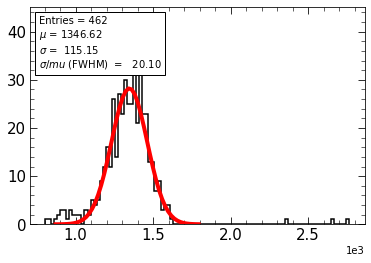

In [79]:
thresholds = np.linspace(0,5,6)
eres_by_thresh = []
eres_err_by_thresh = []
eres_qbb_by_thresh = []
mean_by_thresh = []
sigma_by_thresh = []
sipms_s2_sum = np.sum(sipms_s2, axis=2)
thresh = 2
z_sipms_s2 = sipms_s2_sum
z_sipms_s2[z_sipms_s2 <= thresh] = 0
shape = np.shape(sipms_s2_sum)
z_sipms_s2 = np.reshape(z_sipms_s2, shape)
z_s2_sum = np.sum(z_sipms_s2, axis=1)
print(np.shape(z_s2_sum))
fe = fit_energy(z_s2_sum, 100, (np.min(z_s2_sum), np.max(z_s2_sum)))
eres, err, eres_qbb, sigma, mean = eres_err(fe)
eres_by_thresh.append(eres)
eres_qbb_by_thresh.append(eres_qbb)
eres_err_by_thresh.append(err)
mean_by_thresh.append(mean)
sigma_by_thresh.append(sigma)
 
plot_fit_energy(fe)
#plt.hist(z_s2_sum, bins=50, label="SiPM Threshold = "+str(thresh))
#plt.show()

(462,)
(462,)
(462,)
(462,)
(462,)
(462,)


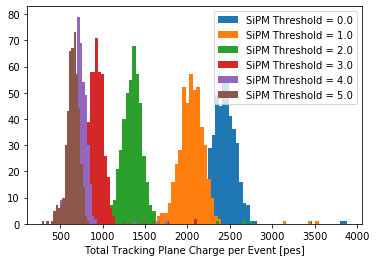

In [53]:
thresholds = np.linspace(0,5,6)
eres_by_thresh = []
eres_err_by_thresh = []
eres_qbb_by_thresh = []
mean_by_thresh = []
sigma_by_thresh = []
sipms_s2_sum = np.sum(sipms_s2, axis=2)
for thresh in thresholds:
    z_sipms_s2 = sipms_s2_sum
    z_sipms_s2[z_sipms_s2 <= thresh] = 0
    shape = np.shape(sipms_s2_sum)
    z_sipms_s2 = np.reshape(z_sipms_s2, shape)
    z_s2_sum = np.sum(z_sipms_s2, axis=1)
    print(np.shape(z_s2_sum))
    fe = fit_energy(z_s2_sum, 100, (np.min(z_s2_sum), np.max(z_s2_sum)))
    eres, err, eres_qbb, sigma, mean = eres_err(fe)
    eres_by_thresh.append(eres)
    eres_qbb_by_thresh.append(eres_qbb)
    eres_err_by_thresh.append(err)
    mean_by_thresh.append(mean)
    sigma_by_thresh.append(sigma)
    
    plt.hist(z_s2_sum, bins=50, label="SiPM Threshold = "+str(thresh))

#plt.title('Zero Suppressed')
plt.xlabel('Total Tracking Plane Charge per Event [pes]')
plt.legend()
plt.show()

462


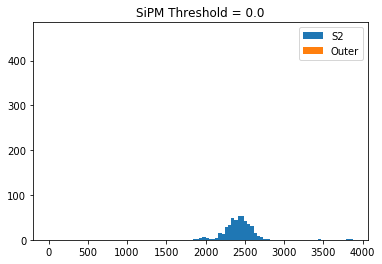

462


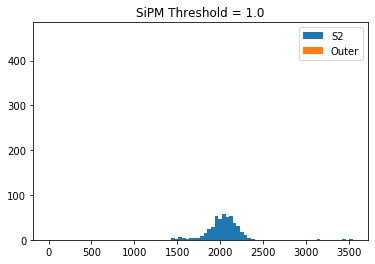

462


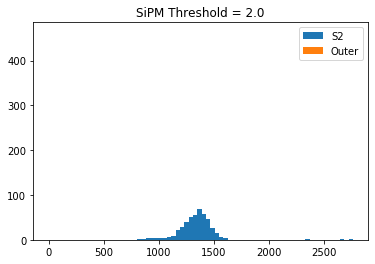

462


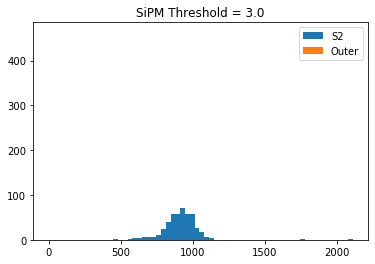

462


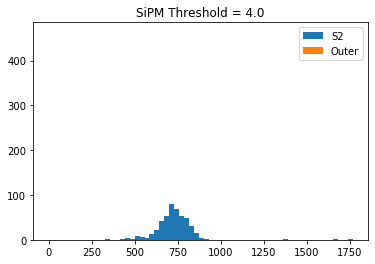

462


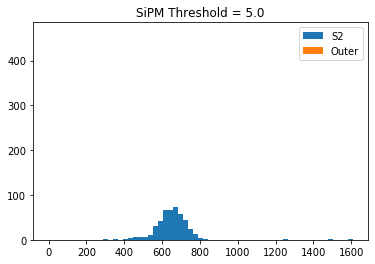

No handles with labels found to put in legend.


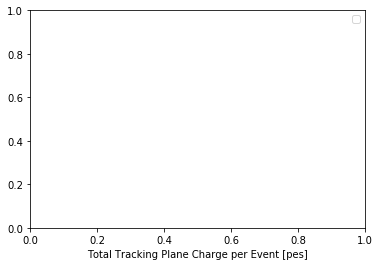

In [85]:
thresholds = np.linspace(0,5,6)
eres_by_thresh = []
eres_err_by_thresh = []
eres_qbb_by_thresh = []
mean_by_thresh = []
sigma_by_thresh = []
sipms_s2_sum = np.sum(sipms_s2, axis=2)
sipms_outer_sum = np.sum(sipms_outer, axis=2)
for thresh in thresholds:
    z_sipms_s2 = sipms_s2_sum
    z_sipms_s2[z_sipms_s2 <= thresh] = 0
    shape = np.shape(sipms_s2_sum)
    z_sipms_s2 = np.reshape(z_sipms_s2, shape)
    z_s2_sum = np.sum(z_sipms_s2, axis=1)
    fe = fit_energy(z_s2_sum, 100, (np.min(z_s2_sum), np.max(z_s2_sum)))
    eres, err, eres_qbb, sigma, mean = eres_err(fe)
    eres_by_thresh.append(eres)
    eres_qbb_by_thresh.append(eres_qbb)
    eres_err_by_thresh.append(err)
    mean_by_thresh.append(mean)
    sigma_by_thresh.append(sigma)
    
    z_sipms_outer = sipms_outer_sum
    z_sipms_outer[z_sipms_outer <= thresh] = 0
    shape = np.shape(sipms_outer_sum)
    z_sipms_outer = np.reshape(z_sipms_outer, shape)
    z_outer_sum = np.sum(z_sipms_outer, axis=1)
    print(len(z_outer_sum))
    
    plt.hist(z_s2_sum, bins=50, label="S2")
    plt.hist(z_outer_sum, bins=50, label="Outer")
    plt.title("SiPM Threshold = "+str(thresh))
    plt.legend()
    plt.show()

#plt.title('Zero Suppressed')
plt.xlabel('Total Tracking Plane Charge per Event [pes]')
plt.legend()
plt.show()

In [54]:
thresh = 2
z_sipms_s2 = sipms_s2_sum
z_sipms_s2[z_sipms_s2 <= thresh] = 0
shape = np.shape(sipms_s2_sum)
z_sipms_s2 = np.reshape(z_sipms_s2, shape)
z_s2_sum = np.sum(z_sipms_s2, axis=1)

In [55]:
cluster = {"sthresh": 2, "d": 1200, "s2": [2524.064325083067, 2362.7748996773057, 2333.6084267503065, 2320.0539354077237, 2278.480927215173, 2323.947302886946, 1962.3926501152312, 2492.6534975285563, 1959.37597996831, 2534.4291182620545, 2265.984343716413, 2309.527566992826, 2527.7798780819894, 2496.806823927589, 2645.7277445210643, 2153.5936331935413, 2382.538230042777, 2466.707337637661, 2494.5929585985295, 2272.15420912807, 2369.5706492570803, 2441.0271894316143, 2593.06631128926, 2365.1681447953383, 2348.6162542309603, 2299.5078740175654, 2176.3689673974272, 2282.2013489364945, 2445.1992131996844, 3816.1638810554505, 2531.439447145626, 1980.128978663615, 2610.0714783596122, 2403.3147697480745, 2164.238361275716, 2377.9480173484176, 2361.3724151885954, 1859.3765338189135, 2113.7677688416456, 2395.8672479382158, 2344.2134020584335, 2292.74761263534, 2259.023554509784, 2137.32057037337, 2338.3946979947946, 2412.203352078004, 2358.74392902545, 2242.893694907284, 2401.951857980502, 2350.1912139732694, 2354.6739015185985, 2195.0387159832107, 2453.6094768057046, 2355.619023929301, 2434.3376867483853, 2433.538226698333, 2171.858806863627, 2262.2999327421016, 2433.360078279298, 2457.233148165057, 2540.03568774994, 2191.8680155631473, 2470.813661524179, 2665.756026023745, 2307.043972153424, 2543.744759133473, 2202.376568625545, 2142.5704694223245, 2358.949391655784, 2276.2053527851326, 2702.7742345577153, 2007.1610934497526, 2298.549251343334, 2527.872775201421, 2448.9786824845733, 2335.559442260485, 2404.8787387924162, 1931.8952950520134, 2335.5148790678827, 2565.7182169214125, 2321.708989734472, 2272.9729430176894, 2289.8620010230643, 2128.285613615187, 2338.879025216199, 2360.3011691233246, 1939.786129157231, 2559.8672814294655, 2456.5067326877515, 2398.1161784806054, 2432.453336819831, 2471.50648121737, 2238.917879001116, 2261.9171202344414, 2253.8234038803876, 2350.6893362476867, 2541.6039230211713, 2555.127527797596, 2527.1980014581995, 2311.4820163406675, 2477.8069394493787, 2369.834754314198, 2266.245854788807, 2385.5188524501727, 2508.2531979132214, 2230.8124704428274, 2362.876856688467, 2336.799898984881, 2437.6061472006213, 2315.568586019912, 2369.9758978551954, 2373.072970153379, 2568.7280909141273, 2417.159906047026, 1981.696191603924, 2031.1572737648564, 1914.808903494622, 2575.3977130364815, 2440.766416059811, 2578.406118151211, 2359.8428305551365, 2469.0468837721396, 2311.2818904272785, 2334.7642722653254, 2333.4667918029813, 2252.765940625795, 2434.4277956681467, 2351.249214860665, 2197.609455417233, 2267.763235388775, 2546.8788646962666, 2194.551208179414, 1835.7239555216636, 2472.1134460350436, 2423.6053763492264, 2459.8246563291755, 1953.3531202967486, 2372.2669436173887, 2363.067701016035, 2383.4587128951357, 2464.2510803190853, 2274.2817306962575, 2565.643418325024, 2437.8061571430217, 2324.358964911169, 2259.760248460013, 2372.798076827934, 2155.999644647071, 2469.3966515377438, 2516.5269478529467, 2404.156427206379, 2206.1171996979942, 2426.3876803530575, 2474.425458744827, 2643.0192910417336, 2198.7144755340073, 2219.1668373169673, 2367.8563560369316, 2364.5470522936243, 2482.209625359399, 2445.5497652114227, 2166.64533716559, 2228.2777751035997, 2555.606515473003, 2200.309801464962, 2428.3377300301554, 2648.034548441868, 2692.629051440638, 2280.7413647431713, 2457.0222221379763, 2362.9273808579374, 2533.468439506585, 2505.485122530754, 2310.051433669158, 2056.4140373603395, 2470.4166651482556, 2676.9317425330855, 2368.783080136938, 2214.258749616449, 2266.7554568367677, 3465.1124599815325, 2432.113785572228, 2423.8326121008445, 2296.4580314783225, 2491.191694547807, 2338.03434328423, 1944.6565502487413, 2296.07914218957, 2038.8695613394716, 2402.6910754288315, 2186.292236517616, 2455.6593032111878, 2240.656000108213, 2075.425219081204, 2226.5042289941016, 2307.3872438188732, 2276.467620871579, 1997.9769084677255, 2370.6555807911323, 2488.0801155567196, 2331.702037520055, 2240.78726107201, 2419.4998456095877, 1990.6434838015898, 1972.7614745936455, 2402.7744497227077, 2175.067327711912], "eres": 13.955430548128982}

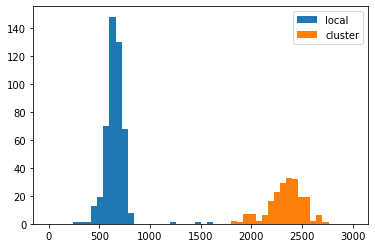

In [56]:
bins = 50
this_range = (0,3000)
plt.hist(z_s2_sum, bins=bins, range=this_range, label='local')
plt.hist(cluster['s2'], bins=bins, range=this_range, label='cluster')
plt.legend()
plt.show()

In [57]:

for event in range(nevents): 
    within_lm_radius = xya.get_nearby_sipm_inds(sipm_xys[max_sipms[event]], d, sipm_xys)
    s2_rcut_data.append(np.sum(sipms_s2[event,within_lm_radius,:]))

ValueError: operands could not be broadcast together with shapes (1790,2) (10,2) 

In [ ]:
len(cluster['s2'])

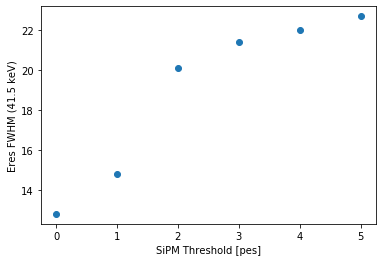

In [58]:
plt.plot(thresholds, eres_by_thresh, 'o')
plt.xlabel('SiPM Threshold [pes]')
plt.ylabel('Eres FWHM (41.5 keV)')
plt.show()

In [59]:
print(np.shape(z_s2_sum))

(462,)


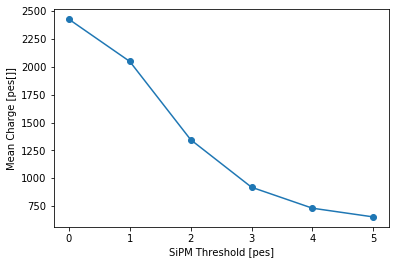

In [60]:
plt.plot(thresholds, mean_by_thresh, 'o-')
plt.xlabel('SiPM Threshold [pes]')
plt.ylabel('Mean Charge [pes[]]')
plt.show()

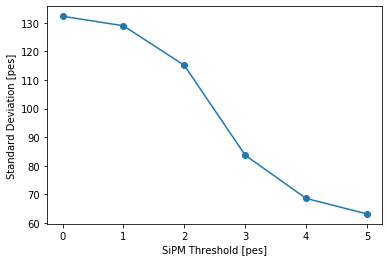

In [61]:
plt.plot(thresholds, sigma_by_thresh, 'o-')
plt.xlabel('SiPM Threshold [pes]')
plt.ylabel('Standard Deviation [pes]')
plt.show()

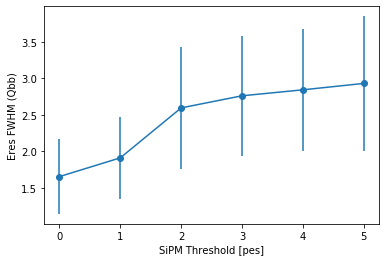

In [62]:
plt.errorbar(thresholds, eres_qbb_by_thresh, yerr=eres_err_by_thresh, marker='o')
plt.xlabel('SiPM Threshold [pes]')
plt.ylabel('Eres FWHM (Qbb)')
plt.show()

<ErrorbarContainer object of 3 artists>

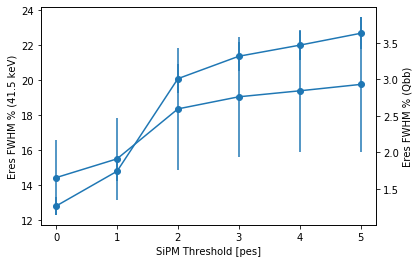

In [63]:
fig, ax1 = plt.subplots()
 
ax1.set_xlabel('SiPM Threshold [pes]')
ax1.set_ylabel('Eres FWHM % (41.5 keV)')
ax1.errorbar(thresholds, eres_by_thresh, yerr=eres_err_by_thresh, marker='o')
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
ax2.set_ylabel('Eres FWHM % (Qbb)')
ax2.errorbar(thresholds, eres_qbb_by_thresh, yerr=eres_err_by_thresh, marker='o')

In [64]:
mean = np.mean(z_s2_sum)
std = np.std(z_s2_sum)
N = np.shape(z_s2_sum)[0]
err_mean = std/np.sqrt(N)
err_std = std/np.sqrt(2 * (N - 1))
this_eres_err = (2.35*100/mean)*np.sqrt(err_std**2. + (std**2. / mean**2.)*err_mean**2.)
std_u = std / np.sqrt(2 * (N -1))
print(err_std, std_u)
print(this_eres_err, eres_err_by_thresh)

3.2743455789928233 3.2743455789928233
1.2107825762772082 [0.5109603537219162, 0.5578927685637971, 0.833441168577344, 0.8185774508216009, 0.8372476258901537, 0.9196959705328746]


In [1]:
data_ = [{"sthresh": 0, "d": 10, "s2": [284.77698584494357, 388.35841708670046, 450.7723010410394, 276.9649467229291, 362.624280989345, 398.6340330554934, 320.35139553942025, 389.70360517904174, 433.32023960348937, 389.76036270420843, 317.7448772920817, 407.2215541942576, 288.2785665843282, 340.13026655966047, 449.81895888673967, 306.9390124488481, 268.15925126700813, 427.7144657173518, 294.5778724330038, 283.7798650485154, 335.8163476385174, 300.8806420793839, 380.03686958171437, 251.09616872071328, 404.74805948335495, 315.43060756683724, 284.3919600557755, 246.23377426249908, 220.6699013194188, 209.1874759966294, 453.0985121312043, 386.13892720155405, 422.42729811063026, 388.12961919991074, 282.50582115270976, 414.0829243004573, 411.7403967977417, 386.85249657654697, 158.4249702151887, 284.39689101355583, 341.0205458737489, 363.9172775181361, 306.20666382751887, 302.170193779488, 408.7576441544505, 246.81097721350474, 467.2739130018996, 370.0697884156036, 370.6952565941693, 425.59616472367395, 272.3656763182604, 422.8291775493411, 231.01901158005307, 311.74925782539975, 302.6458994942513, 336.8237003343427, 403.78556181969276, 267.10511279144026, 424.8524799900824, 365.39940710479436, 278.2161388146405, 241.97163312634132, 356.8372107891531, 641.6831232907942, 276.99467848981794, 307.60350123361707, 254.6538380003591, 312.9693209139935, 289.4731219838655, 264.11756124989967, 355.90765608924306, 315.1136411173417, 332.96852102193344, 564.4863372398346, 304.4271415459319, 307.2885697206538, 376.224014583487, 278.19667203928987, 228.92651057460898, 310.97278719138717, 351.3389224098129, 217.09644913240618, 248.77334602586893, 290.9520255929163, 273.801555075601, 406.1710137937577, 393.74340740281906, 421.01621361594954, 396.6716571917223, 465.528136043782, 258.44326250932085, 427.11581703391096, 294.80650654710183, 320.20027866122985, 217.93004718102108, 321.63080811672745, 418.85023702809855, 309.1647387131632, 230.97471700633272, 498.6416278161546, 339.2056986593899, 444.21072229675076, 358.43294090865555, 444.9999254818764, 214.90164207487172, 195.0806990607523, 422.76680753711827, 379.38062090336336, 285.26709360191273, 351.9772482357826, 315.3926841975351, 252.4531606739488, 295.52634137811805, 304.0624617552662, 360.81849009082754, 334.1606904460286, 395.50926565383594, 323.91764915858556, 453.01150190219545, 381.70434458473744, 333.43442937206896, 339.1381578039001, 273.068358361277, 196.74704009733617, 391.97211682155387, 422.2096388668319, 290.91440943805065, 394.14861855957014, 305.8487145022998, 338.4765400459863, 352.30421549708603, 370.5949592864319, 337.6929157114545, 272.8829485562877, 343.85111011975386, 339.1858391094832, 311.3712912923139, 254.84551533533616, 304.6938121352491, 458.8728510442272, 272.70850954414857, 297.21831002338354, 342.7682707130359, 329.7146936617496, 210.1078855912955, 277.54770373892256, 204.37846822983545, 497.7980654901592, 372.5035212619806, 215.4228754729583, 287.94824567833024, 278.0603803129984, 329.2446694064537, 376.3880944382265, 362.08479171145166, 359.94620760296124], "outer": [7.084456584058172, 10.671865805093761, 7.824263371525052, 6.911789147796496, 6.956158357211745, 11.025370690058846, 9.486547709758117, 9.008924633145332, 10.385133574411405, 5.263122808501579, 8.208925024883952, 9.300881848962366, 8.334710691348542, 6.256120287639897, 10.790894055528868, 9.520503400749579, 6.580179971652857, 11.094159999914861, 5.024613285889463, 8.588395563314606, 8.362706991316413, 7.444153669752409, 8.83961038102985, 7.955294316242785, 8.494452272059352, 8.06188327400954, 8.721345812604262, 6.642462526638981, 11.317379971875598, 7.819144663541712, 10.401534520733456, 11.461198763192506, 5.757926260746511, 8.597464074018308, 6.581761539996651, 7.508304490998544, 16.290712592599665, 4.76518006381861, 11.314158326856454, 8.349560839980583, 6.75142575956663, 8.296330220009919, 9.259275456668526, 7.269997070914087, 8.768303674616776, 12.203500179172336, 8.367810771013131, 7.4740280741950516, 8.355216879646118, 6.375864066839959, 7.1060437424187, 8.657912354492893, 6.848230315015859, 11.299089523863836, 8.22795623670042, 5.754745522418811, 12.453883626336289, 8.389023732753351, 10.70689705513992, 9.52041995444507, 7.086545425662811, 9.504098178535404, 9.139196380737172, 15.705103441633108, 10.877821685182148, 8.415481826430575, 6.785688529164607, 11.58346367013499, 7.4862092573639245, 7.125115086760539, 7.354193229499132, 9.149470477117152, 8.895954212233786, 9.51111981782062, 6.805634590848953, 9.107633249137773, 6.982528943761676, 7.093808635110855, 13.449941363972096, 8.3030267423159, 8.941540315242586, 8.241531164571326, 8.193005717776431, 6.017936071399597, 5.361360974740297, 6.931907541640798, 9.77421057935485, 13.492298635214947, 7.2987258048340005, 9.664499419920158, 10.433733996090902, 6.762426754223712, 12.428561648079603, 6.717575538285825, 6.11897704620585, 6.1216361028653115, 7.20886724114775, 11.029639491718925, 6.13254634999756, 8.129074637885711, 7.463729538380585, 6.931449229440964, 9.409244461230905, 7.346978551649258, 7.995671439321559, 5.429636430883843, 4.574565196949596, 10.212846258707648, 10.395753541440532, 9.315464004975341, 6.7317340020793965, 7.303445798641044, 6.3912773759179675, 7.169068750466991, 5.425739171047726, 6.960504421819803, 9.825050906768688, 12.047630016475022, 9.969538926870277, 9.407592631952257, 11.39059345114632, 8.888710235746654, 7.179556679260511, 11.011474365591823, 9.609167613976732, 9.41664553944018, 6.072394212046001, 6.94292615191685, 7.375526135584295, 7.430174878771344, 6.257046929668654, 7.935181334225789, 6.507356561974205, 8.150346710056624, 13.049667476033877, 9.058911430284502, 11.968610427460792, 6.748549292743856, 6.517434268093714, 10.14525483262954, 9.012668204345141, 6.79121768883256, 6.501951828621254, 6.481413464309701, 7.756859675823578, 5.478378391205236, 9.307787137398899, 9.198298179931239, 10.045660144863696, 7.144274615789894, 9.60263614021544, 7.976611310536873, 5.943313322340901, 8.329082586658258, 5.970269852151381, 6.604755865291334]}, {"sthresh": 0, "d": 20, "s2": [489.08817069129407, 593.4343185492401, 613.6570801881351, 467.06089085976157, 572.4758595315327, 605.100713163466, 510.1871032825613, 562.6064743826088, 565.2729503036126, 577.7107342981551, 483.32970406386596, 568.7552120015694, 478.24859178503834, 514.2978810864098, 568.9404208362411, 482.3528029963574, 470.8958106878772, 582.8721837839721, 489.3331557812167, 492.3902067135558, 564.1095913114773, 438.63313070883635, 531.1393659896007, 381.9123327557287, 577.6038025512721, 514.9669851569399, 477.4936839542609, 457.8579265013651, 435.65478839070886, 369.59919278052905, 597.134917833175, 549.1951690335768, 569.0717265843375, 574.8983699309658, 484.6612533405308, 612.3895342841759, 596.6478354692774, 594.8724536728512, 329.5135405568559, 447.73590629074795, 500.7701798153589, 553.1551142172266, 518.1312163522987, 466.35024339841334, 588.0280229502944, 423.1315071807116, 624.7795300563425, 534.7504975917384, 474.051848060398, 582.9402328943931, 468.44900415024256, 559.5134056886471, 389.01191404603304, 472.72315060679057, 491.6011840304537, 495.9333592034968, 557.4911963634876, 428.4536571431131, 601.8177017031717, 499.8331101865818, 449.82632184487886, 443.36162377818863, 559.3819266081678, 1050.719799114036, 468.19839303989033, 493.5583097296354, 387.4994565267724, 496.8653561422449, 487.09305653276897, 482.5724116509039, 527.1525006622377, 469.1132878369007, 495.72308380142374, 682.8623289142606, 502.8119411796022, 526.1589186738174, 535.3561798331309, 459.79455297577897, 366.56730408624867, 507.93237354762084, 492.7679874407304, 398.2375269715045, 410.4430377427824, 444.56119034109236, 440.1447573943384, 597.7386988171808, 581.4838950667292, 602.6317799136885, 539.835343516866, 629.7252017238281, 460.27427221806386, 543.7839200681594, 491.24606171206386, 509.2658504651967, 416.5332424359124, 516.1716790003381, 566.1076477829121, 515.958601333768, 416.61427505195957, 637.2818179001658, 522.2801810931286, 595.4529165877377, 553.6454486113757, 604.9133335512508, 389.6605669984164, 363.98320212569365, 593.1252737942912, 582.2944140842508, 477.2031032836023, 543.2589183047455, 498.01768459024754, 439.5740719771736, 497.7582235260319, 487.90951358133725, 473.52170568198073, 550.3694398709637, 635.5545495016013, 501.9474836066292, 568.3589538170713, 591.0924743389778, 500.4468231943721, 516.7521972962322, 462.6694149806582, 385.23451209924065, 556.193141796421, 598.2396686798076, 476.6475062350645, 595.5651398820658, 467.1641058601494, 546.1073978174827, 515.9872583215849, 576.612302170812, 502.4237824192984, 446.91873030119706, 533.0433389098454, 530.0196148583157, 504.20651945841047, 414.5573192959729, 501.057627575129, 601.4563751819718, 467.15642447637305, 507.23738204463723, 503.3615061635855, 525.4921136755568, 403.690974097749, 497.78962441012686, 396.2975225923568, 649.2368446191379, 516.5233124409081, 371.6695063101082, 501.2759924029082, 475.0905102262225, 534.108722623613, 608.9761250446523, 582.5837891274301, 540.8547634370702], "outer": [9.25614531362624, 13.365951379303219, 12.852490354206099, 12.383447909641749, 12.738548623413262, 16.192089266260595, 22.9595353375467, 16.38156359665075, 18.308395035734442, 8.176552060519107, 14.177030344441878, 23.75651014609563, 13.134698462801918, 12.120368512797556, 18.17337279099574, 13.01355449751851, 11.723527902776794, 16.47359653152864, 6.546251308874572, 12.51901251593063, 14.088314878561459, 14.74435563195377, 13.352471714971749, 12.682698522568483, 13.255613292937204, 12.442745431126749, 14.096785460930342, 9.670993843680458, 16.065163363281744, 12.450809895614112, 19.70904694162435, 19.404750473881165, 10.681943827710388, 12.792390622974796, 11.691342552000524, 12.129981764744247, 21.823612982428997, 8.461079757085255, 21.202027931634213, 11.858713304549742, 10.69792304269351, 10.522889462267933, 13.913757887885323, 11.669395386453495, 16.92145239576591, 20.35919813979052, 13.078874856449833, 12.806169662882665, 13.561285499907154, 7.424771723875367, 10.302196660978563, 12.627678184442571, 8.374925883671738, 17.888115808671756, 13.301050848734043, 9.929614527304718, 19.624222642766824, 12.00574714767267, 16.79286324488391, 18.591847167354516, 11.794678575960901, 16.72502823360785, 15.505480825165384, 28.492143869439943, 16.13257575403538, 11.333716718563954, 10.448703547966, 18.88481364365967, 12.59081299569105, 15.8281077576368, 16.809934632417193, 15.911719645805606, 9.86327161910154, 15.68197334302914, 8.275451444398175, 17.95764542921993, 12.003255453352686, 10.486345503673697, 18.297314120122255, 12.825326844154333, 13.069922537217252, 13.593154863587303, 13.173384651125389, 14.467374929105286, 9.35329776121117, 13.351769523621723, 18.011577470903255, 17.79960501572033, 16.905542238922337, 16.956441535482877, 17.156880145871835, 7.654070675368799, 22.442050777262608, 11.64278318964965, 9.942641602950307, 9.704448092735666, 18.472808573442492, 17.261301459283818, 9.66385460484839, 16.786523638894806, 13.54284660369857, 13.081351032973604, 18.392355310938278, 13.059167593869333, 13.912085672071047, 7.735280700576274, 9.246495837386767, 18.079671085020482, 17.123857795772956, 18.43123677232667, 14.114729559041349, 12.780377539592248, 12.323121481296495, 12.907221139569144, 10.583806562924375, 12.5613847176011, 14.026354994264022, 19.271005189036206, 16.86423747597127, 14.019057663793305, 18.78969575558759, 13.273462178853556, 9.779516745883011, 19.993770267799448, 16.159833170282077, 15.23209428674753, 13.220188453304871, 10.365075977585427, 11.252781400725716, 17.2674606890662, 15.010067398679318, 16.575543881802634, 13.707742942199243, 12.73381132610968, 17.080676298896407, 13.554499659467872, 21.127823567698023, 12.026153399969811, 12.797514564524953, 16.033018260168618, 12.666433507584511, 12.717914123863817, 13.326916638090792, 11.230470501598049, 12.343385663368345, 6.9795282000233465, 17.50252166302257, 15.137848593273537, 18.162165962283204, 12.495223297386218, 18.456499085341576, 13.682467656999576, 11.06657293066467, 13.172810390592138, 10.891345948756717, 9.898081913323022]}, {"sthresh": 2, "d": 10, "s2": [284.77698584494357, 388.35841708670046, 450.7723010410394, 276.9649467229291, 362.624280989345, 398.6340330554934, 320.35139553942025, 389.70360517904174, 433.32023960348937, 389.76036270420843, 317.7448772920817, 407.2215541942576, 288.2785665843282, 340.13026655966047, 449.81895888673967, 306.9390124488481, 268.15925126700813, 427.7144657173518, 294.5778724330038, 283.7798650485154, 335.8163476385174, 300.8806420793839, 380.03686958171437, 251.09616872071328, 404.74805948335495, 315.43060756683724, 284.3919600557755, 246.23377426249908, 220.6699013194188, 209.1874759966294, 453.0985121312043, 386.13892720155405, 422.42729811063026, 388.12961919991074, 282.50582115270976, 414.0829243004573, 411.7403967977417, 386.85249657654697, 158.4249702151887, 284.39689101355583, 341.0205458737489, 363.9172775181361, 306.20666382751887, 302.170193779488, 408.7576441544505, 246.81097721350474, 467.2739130018996, 370.0697884156036, 370.6952565941693, 425.59616472367395, 272.3656763182604, 422.8291775493411, 231.01901158005307, 311.74925782539975, 302.6458994942513, 336.8237003343427, 403.78556181969276, 267.10511279144026, 424.8524799900824, 365.39940710479436, 278.2161388146405, 241.97163312634132, 356.8372107891531, 641.6831232907942, 276.99467848981794, 307.60350123361707, 254.6538380003591, 312.9693209139935, 289.4731219838655, 264.11756124989967, 355.90765608924306, 315.1136411173417, 332.96852102193344, 564.4863372398346, 304.4271415459319, 307.2885697206538, 376.224014583487, 278.19667203928987, 228.92651057460898, 310.97278719138717, 351.3389224098129, 217.09644913240618, 248.77334602586893, 290.9520255929163, 273.801555075601, 406.1710137937577, 393.74340740281906, 421.01621361594954, 396.6716571917223, 465.528136043782, 258.44326250932085, 427.11581703391096, 294.80650654710183, 320.20027866122985, 217.93004718102108, 321.63080811672745, 418.85023702809855, 309.1647387131632, 230.97471700633272, 498.6416278161546, 339.2056986593899, 444.21072229675076, 358.43294090865555, 444.9999254818764, 214.90164207487172, 195.0806990607523, 422.76680753711827, 379.38062090336336, 285.26709360191273, 351.9772482357826, 315.3926841975351, 252.4531606739488, 295.52634137811805, 304.0624617552662, 360.81849009082754, 334.1606904460286, 395.50926565383594, 323.91764915858556, 453.01150190219545, 381.70434458473744, 333.43442937206896, 339.1381578039001, 273.068358361277, 196.74704009733617, 391.97211682155387, 422.2096388668319, 290.91440943805065, 394.14861855957014, 305.8487145022998, 338.4765400459863, 352.30421549708603, 370.5949592864319, 337.6929157114545, 272.8829485562877, 343.85111011975386, 339.1858391094832, 311.3712912923139, 254.84551533533616, 304.6938121352491, 458.8728510442272, 272.70850954414857, 297.21831002338354, 342.7682707130359, 329.7146936617496, 210.1078855912955, 277.54770373892256, 204.37846822983545, 497.7980654901592, 372.5035212619806, 215.4228754729583, 287.94824567833024, 278.0603803129984, 329.2446694064537, 376.3880944382265, 362.08479171145166, 359.94620760296124], "outer": [7.084456584058172, 10.671865805093761, 7.824263371525052, 6.911789147796496, 6.956158357211745, 11.025370690058846, 9.486547709758117, 9.008924633145332, 10.385133574411405, 5.263122808501579, 8.208925024883952, 9.300881848962366, 8.334710691348542, 6.256120287639897, 10.790894055528868, 9.520503400749579, 6.580179971652857, 11.094159999914861, 5.024613285889463, 8.588395563314606, 8.362706991316413, 7.444153669752409, 8.83961038102985, 7.955294316242785, 8.494452272059352, 8.06188327400954, 8.721345812604262, 6.642462526638981, 11.317379971875598, 7.819144663541712, 10.401534520733456, 11.461198763192506, 5.757926260746511, 8.597464074018308, 6.581761539996651, 7.508304490998544, 16.290712592599665, 4.76518006381861, 11.314158326856454, 8.349560839980583, 6.75142575956663, 8.296330220009919, 9.259275456668526, 7.269997070914087, 8.768303674616776, 12.203500179172336, 8.367810771013131, 7.4740280741950516, 8.355216879646118, 6.375864066839959, 7.1060437424187, 8.657912354492893, 6.848230315015859, 11.299089523863836, 8.22795623670042, 5.754745522418811, 12.453883626336289, 8.389023732753351, 10.70689705513992, 9.52041995444507, 7.086545425662811, 9.504098178535404, 9.139196380737172, 15.705103441633108, 10.877821685182148, 8.415481826430575, 6.785688529164607, 11.58346367013499, 7.4862092573639245, 7.125115086760539, 7.354193229499132, 9.149470477117152, 8.895954212233786, 9.51111981782062, 6.805634590848953, 9.107633249137773, 6.982528943761676, 7.093808635110855, 13.449941363972096, 8.3030267423159, 8.941540315242586, 8.241531164571326, 8.193005717776431, 6.017936071399597, 5.361360974740297, 6.931907541640798, 9.77421057935485, 13.492298635214947, 7.2987258048340005, 9.664499419920158, 10.433733996090902, 6.762426754223712, 12.428561648079603, 6.717575538285825, 6.11897704620585, 6.1216361028653115, 7.20886724114775, 11.029639491718925, 6.13254634999756, 8.129074637885711, 7.463729538380585, 6.931449229440964, 9.409244461230905, 7.346978551649258, 7.995671439321559, 5.429636430883843, 4.574565196949596, 10.212846258707648, 10.395753541440532, 9.315464004975341, 6.7317340020793965, 7.303445798641044, 6.3912773759179675, 7.169068750466991, 5.425739171047726, 6.960504421819803, 9.825050906768688, 12.047630016475022, 9.969538926870277, 9.407592631952257, 11.39059345114632, 8.888710235746654, 7.179556679260511, 11.011474365591823, 9.609167613976732, 9.41664553944018, 6.072394212046001, 6.94292615191685, 7.375526135584295, 7.430174878771344, 6.257046929668654, 7.935181334225789, 6.507356561974205, 8.150346710056624, 13.049667476033877, 9.058911430284502, 11.968610427460792, 6.748549292743856, 6.517434268093714, 10.14525483262954, 9.012668204345141, 6.79121768883256, 6.501951828621254, 6.481413464309701, 7.756859675823578, 5.478378391205236, 9.307787137398899, 9.198298179931239, 10.045660144863696, 7.144274615789894, 9.60263614021544, 7.976611310536873, 5.943313322340901, 8.329082586658258, 5.970269852151381, 6.604755865291334]}, {"sthresh": 2, "d": 20, "s2": [489.08817069129407, 593.4343185492401, 613.6570801881351, 467.06089085976157, 572.4758595315327, 605.100713163466, 510.1871032825613, 562.6064743826088, 565.2729503036126, 577.7107342981551, 483.32970406386596, 568.7552120015694, 478.24859178503834, 514.2978810864098, 568.9404208362411, 482.3528029963574, 470.8958106878772, 582.8721837839721, 489.3331557812167, 492.3902067135558, 564.1095913114773, 438.63313070883635, 531.1393659896007, 381.9123327557287, 577.6038025512721, 514.9669851569399, 477.4936839542609, 457.8579265013651, 435.65478839070886, 369.59919278052905, 597.134917833175, 549.1951690335768, 569.0717265843375, 574.8983699309658, 484.6612533405308, 612.3895342841759, 596.6478354692774, 594.8724536728512, 329.5135405568559, 447.73590629074795, 500.7701798153589, 553.1551142172266, 518.1312163522987, 466.35024339841334, 588.0280229502944, 423.1315071807116, 624.7795300563425, 534.7504975917384, 474.051848060398, 582.9402328943931, 468.44900415024256, 559.5134056886471, 389.01191404603304, 472.72315060679057, 491.6011840304537, 495.9333592034968, 557.4911963634876, 428.4536571431131, 601.8177017031717, 499.8331101865818, 449.82632184487886, 443.36162377818863, 559.3819266081678, 1050.719799114036, 468.19839303989033, 493.5583097296354, 387.4994565267724, 496.8653561422449, 487.09305653276897, 482.5724116509039, 527.1525006622377, 469.1132878369007, 495.72308380142374, 682.8623289142606, 502.8119411796022, 526.1589186738174, 535.3561798331309, 459.79455297577897, 366.56730408624867, 507.93237354762084, 492.7679874407304, 398.2375269715045, 410.4430377427824, 444.56119034109236, 440.1447573943384, 597.7386988171808, 581.4838950667292, 602.6317799136885, 539.835343516866, 629.7252017238281, 460.27427221806386, 543.7839200681594, 491.24606171206386, 509.2658504651967, 416.5332424359124, 516.1716790003381, 566.1076477829121, 515.958601333768, 416.61427505195957, 637.2818179001658, 522.2801810931286, 595.4529165877377, 553.6454486113757, 604.9133335512508, 389.6605669984164, 363.98320212569365, 593.1252737942912, 582.2944140842508, 477.2031032836023, 543.2589183047455, 498.01768459024754, 439.5740719771736, 497.7582235260319, 487.90951358133725, 473.52170568198073, 550.3694398709637, 635.5545495016013, 501.9474836066292, 568.3589538170713, 591.0924743389778, 500.4468231943721, 516.7521972962322, 462.6694149806582, 385.23451209924065, 556.193141796421, 598.2396686798076, 476.6475062350645, 595.5651398820658, 467.1641058601494, 546.1073978174827, 515.9872583215849, 576.612302170812, 502.4237824192984, 446.91873030119706, 533.0433389098454, 530.0196148583157, 504.20651945841047, 414.5573192959729, 501.057627575129, 601.4563751819718, 467.15642447637305, 507.23738204463723, 503.3615061635855, 525.4921136755568, 403.690974097749, 497.78962441012686, 396.2975225923568, 649.2368446191379, 516.5233124409081, 371.6695063101082, 501.2759924029082, 475.0905102262225, 534.108722623613, 608.9761250446523, 582.5837891274301, 540.8547634370702], "outer": [9.25614531362624, 13.365951379303219, 12.852490354206099, 12.383447909641749, 12.738548623413262, 16.192089266260595, 22.9595353375467, 16.38156359665075, 18.308395035734442, 8.176552060519107, 14.177030344441878, 23.75651014609563, 13.134698462801918, 12.120368512797556, 18.17337279099574, 13.01355449751851, 11.723527902776794, 16.47359653152864, 6.546251308874572, 12.51901251593063, 14.088314878561459, 14.74435563195377, 13.352471714971749, 12.682698522568483, 13.255613292937204, 12.442745431126749, 14.096785460930342, 9.670993843680458, 16.065163363281744, 12.450809895614112, 19.70904694162435, 19.404750473881165, 10.681943827710388, 12.792390622974796, 11.691342552000524, 12.129981764744247, 21.823612982428997, 8.461079757085255, 21.202027931634213, 11.858713304549742, 10.69792304269351, 10.522889462267933, 13.913757887885323, 11.669395386453495, 16.92145239576591, 20.35919813979052, 13.078874856449833, 12.806169662882665, 13.561285499907154, 7.424771723875367, 10.302196660978563, 12.627678184442571, 8.374925883671738, 17.888115808671756, 13.301050848734043, 9.929614527304718, 19.624222642766824, 12.00574714767267, 16.79286324488391, 18.591847167354516, 11.794678575960901, 16.72502823360785, 15.505480825165384, 28.492143869439943, 16.13257575403538, 11.333716718563954, 10.448703547966, 18.88481364365967, 12.59081299569105, 15.8281077576368, 16.809934632417193, 15.911719645805606, 9.86327161910154, 15.68197334302914, 8.275451444398175, 17.95764542921993, 12.003255453352686, 10.486345503673697, 18.297314120122255, 12.825326844154333, 13.069922537217252, 13.593154863587303, 13.173384651125389, 14.467374929105286, 9.35329776121117, 13.351769523621723, 18.011577470903255, 17.79960501572033, 16.905542238922337, 16.956441535482877, 17.156880145871835, 7.654070675368799, 22.442050777262608, 11.64278318964965, 9.942641602950307, 9.704448092735666, 18.472808573442492, 17.261301459283818, 9.66385460484839, 16.786523638894806, 13.54284660369857, 13.081351032973604, 18.392355310938278, 13.059167593869333, 13.912085672071047, 7.735280700576274, 9.246495837386767, 18.079671085020482, 17.123857795772956, 18.43123677232667, 14.114729559041349, 12.780377539592248, 12.323121481296495, 12.907221139569144, 10.583806562924375, 12.5613847176011, 14.026354994264022, 19.271005189036206, 16.86423747597127, 14.019057663793305, 18.78969575558759, 13.273462178853556, 9.779516745883011, 19.993770267799448, 16.159833170282077, 15.23209428674753, 13.220188453304871, 10.365075977585427, 11.252781400725716, 17.2674606890662, 15.010067398679318, 16.575543881802634, 13.707742942199243, 12.73381132610968, 17.080676298896407, 13.554499659467872, 21.127823567698023, 12.026153399969811, 12.797514564524953, 16.033018260168618, 12.666433507584511, 12.717914123863817, 13.326916638090792, 11.230470501598049, 12.343385663368345, 6.9795282000233465, 17.50252166302257, 15.137848593273537, 18.162165962283204, 12.495223297386218, 18.456499085341576, 13.682467656999576, 11.06657293066467, 13.172810390592138, 10.891345948756717, 9.898081913323022]}]
data_test = [{"sthresh": 0, "d": 10, "s2": [276.9649467229291, 398.6340330554934, 288.2785665843282, 340.13026655966047, 306.9390124488481, 294.5778724330038, 300.8806420793839, 380.03686958171437, 251.09616872071328, 404.74805948335495, 284.3919600557755, 246.23377426249908, 220.6699013194188, 386.13892720155405, 386.85249657654697, 158.4249702151887, 341.0205458737489, 363.9172775181361, 408.7576441544505, 246.81097721350474, 370.6952565941693, 272.3656763182604, 422.8291775493411, 302.6458994942513, 336.8237003343427, 267.10511279144026, 365.39940710479436, 278.2161388146405, 241.97163312634132, 641.6831232907942, 307.60350123361707, 254.6538380003591, 264.11756124989967, 355.90765608924306, 315.1136411173417, 304.4271415459319, 376.224014583487, 228.92651057460898, 217.09644913240618, 248.77334602586893, 290.9520255929163, 273.801555075601, 258.44326250932085, 217.93004718102108, 321.63080811672745, 230.97471700633272, 444.9999254818764, 214.90164207487172, 351.9772482357826, 252.4531606739488, 304.0624617552662, 360.81849009082754, 334.1606904460286, 453.01150190219545, 381.70434458473744, 333.43442937206896, 196.74704009733617, 391.97211682155387, 422.2096388668319, 290.91440943805065, 394.14861855957014, 305.8487145022998, 338.4765400459863, 370.5949592864319, 272.8829485562877, 343.85111011975386, 311.3712912923139, 254.84551533533616, 304.6938121352491, 342.7682707130359, 329.7146936617496, 215.4228754729583, 287.94824567833024, 329.2446694064537], "outer": [6.911789147796496, 11.025370690058846, 8.334710691348542, 6.256120287639897, 9.520503400749579, 5.024613285889463, 7.444153669752409, 8.83961038102985, 7.955294316242785, 8.494452272059352, 8.721345812604262, 6.642462526638981, 11.317379971875598, 11.461198763192506, 4.76518006381861, 11.314158326856454, 6.75142575956663, 8.296330220009919, 8.768303674616776, 12.203500179172336, 8.355216879646118, 7.1060437424187, 8.657912354492893, 8.22795623670042, 5.754745522418811, 8.389023732753351, 9.52041995444507, 7.086545425662811, 9.504098178535404, 15.705103441633108, 8.415481826430575, 6.785688529164607, 7.125115086760539, 7.354193229499132, 9.149470477117152, 6.805634590848953, 6.982528943761676, 13.449941363972096, 8.241531164571326, 8.193005717776431, 6.017936071399597, 5.361360974740297, 10.433733996090902, 6.11897704620585, 6.1216361028653115, 6.13254634999756, 7.346978551649258, 7.995671439321559, 9.315464004975341, 7.303445798641044, 7.169068750466991, 5.425739171047726, 6.960504421819803, 9.969538926870277, 9.407592631952257, 11.39059345114632, 11.011474365591823, 9.609167613976732, 9.41664553944018, 6.072394212046001, 6.94292615191685, 7.375526135584295, 7.430174878771344, 7.935181334225789, 8.150346710056624, 13.049667476033877, 11.968610427460792, 6.748549292743856, 6.517434268093714, 6.501951828621254, 6.481413464309701, 7.144274615789894, 9.60263614021544, 5.943313322340901]}, {"sthresh": 0, "d": 20, "s2": [467.06089085976157, 605.100713163466, 478.24859178503834, 514.2978810864098, 482.3528029963574, 489.3331557812167, 438.63313070883635, 531.1393659896007, 381.9123327557287, 577.6038025512721, 477.4936839542609, 457.8579265013651, 435.65478839070886, 549.1951690335768, 594.8724536728512, 329.5135405568559, 500.7701798153589, 553.1551142172266, 588.0280229502944, 423.1315071807116, 474.051848060398, 468.44900415024256, 559.5134056886471, 491.6011840304537, 495.9333592034968, 428.4536571431131, 499.8331101865818, 449.82632184487886, 443.36162377818863, 1050.719799114036, 493.5583097296354, 387.4994565267724, 482.5724116509039, 527.1525006622377, 469.1132878369007, 502.8119411796022, 535.3561798331309, 366.56730408624867, 398.2375269715045, 410.4430377427824, 444.56119034109236, 440.1447573943384, 460.27427221806386, 416.5332424359124, 516.1716790003381, 416.61427505195957, 604.9133335512508, 389.6605669984164, 543.2589183047455, 439.5740719771736, 487.90951358133725, 473.52170568198073, 550.3694398709637, 568.3589538170713, 591.0924743389778, 500.4468231943721, 385.23451209924065, 556.193141796421, 598.2396686798076, 476.6475062350645, 595.5651398820658, 467.1641058601494, 546.1073978174827, 576.612302170812, 446.91873030119706, 533.0433389098454, 504.20651945841047, 414.5573192959729, 501.057627575129, 503.3615061635855, 525.4921136755568, 371.6695063101082, 501.2759924029082, 534.108722623613], "outer": [12.383447909641749, 16.192089266260595, 13.134698462801918, 12.120368512797556, 13.01355449751851, 6.546251308874572, 14.74435563195377, 13.352471714971749, 12.682698522568483, 13.255613292937204, 14.096785460930342, 9.670993843680458, 16.065163363281744, 19.404750473881165, 8.461079757085255, 21.202027931634213, 10.69792304269351, 10.522889462267933, 16.92145239576591, 20.35919813979052, 13.561285499907154, 10.302196660978563, 12.627678184442571, 13.301050848734043, 9.929614527304718, 12.00574714767267, 18.591847167354516, 11.794678575960901, 16.72502823360785, 28.492143869439943, 11.333716718563954, 10.448703547966, 15.8281077576368, 16.809934632417193, 15.911719645805606, 8.275451444398175, 12.003255453352686, 18.297314120122255, 13.593154863587303, 13.173384651125389, 14.467374929105286, 9.35329776121117, 17.156880145871835, 9.942641602950307, 9.704448092735666, 9.66385460484839, 13.059167593869333, 13.912085672071047, 18.43123677232667, 12.780377539592248, 12.907221139569144, 10.583806562924375, 12.5613847176011, 16.86423747597127, 14.019057663793305, 18.78969575558759, 19.993770267799448, 16.159833170282077, 15.23209428674753, 13.220188453304871, 10.365075977585427, 11.252781400725716, 17.2674606890662, 16.575543881802634, 12.73381132610968, 17.080676298896407, 21.127823567698023, 12.026153399969811, 12.797514564524953, 13.326916638090792, 11.230470501598049, 12.495223297386218, 18.456499085341576, 11.06657293066467]}, {"sthresh": 2, "d": 10, "s2": [276.9649467229291, 398.6340330554934, 288.2785665843282, 340.13026655966047, 306.9390124488481, 294.5778724330038, 300.8806420793839, 380.03686958171437, 251.09616872071328, 404.74805948335495, 284.3919600557755, 246.23377426249908, 220.6699013194188, 386.13892720155405, 386.85249657654697, 158.4249702151887, 341.0205458737489, 363.9172775181361, 408.7576441544505, 246.81097721350474, 370.6952565941693, 272.3656763182604, 422.8291775493411, 302.6458994942513, 336.8237003343427, 267.10511279144026, 365.39940710479436, 278.2161388146405, 241.97163312634132, 641.6831232907942, 307.60350123361707, 254.6538380003591, 264.11756124989967, 355.90765608924306, 315.1136411173417, 304.4271415459319, 376.224014583487, 228.92651057460898, 217.09644913240618, 248.77334602586893, 290.9520255929163, 273.801555075601, 258.44326250932085, 217.93004718102108, 321.63080811672745, 230.97471700633272, 444.9999254818764, 214.90164207487172, 351.9772482357826, 252.4531606739488, 304.0624617552662, 360.81849009082754, 334.1606904460286, 453.01150190219545, 381.70434458473744, 333.43442937206896, 196.74704009733617, 391.97211682155387, 422.2096388668319, 290.91440943805065, 394.14861855957014, 305.8487145022998, 338.4765400459863, 370.5949592864319, 272.8829485562877, 343.85111011975386, 311.3712912923139, 254.84551533533616, 304.6938121352491, 342.7682707130359, 329.7146936617496, 215.4228754729583, 287.94824567833024, 329.2446694064537], "outer": [6.911789147796496, 11.025370690058846, 8.334710691348542, 6.256120287639897, 9.520503400749579, 5.024613285889463, 7.444153669752409, 8.83961038102985, 7.955294316242785, 8.494452272059352, 8.721345812604262, 6.642462526638981, 11.317379971875598, 11.461198763192506, 4.76518006381861, 11.314158326856454, 6.75142575956663, 8.296330220009919, 8.768303674616776, 12.203500179172336, 8.355216879646118, 7.1060437424187, 8.657912354492893, 8.22795623670042, 5.754745522418811, 8.389023732753351, 9.52041995444507, 7.086545425662811, 9.504098178535404, 15.705103441633108, 8.415481826430575, 6.785688529164607, 7.125115086760539, 7.354193229499132, 9.149470477117152, 6.805634590848953, 6.982528943761676, 13.449941363972096, 8.241531164571326, 8.193005717776431, 6.017936071399597, 5.361360974740297, 10.433733996090902, 6.11897704620585, 6.1216361028653115, 6.13254634999756, 7.346978551649258, 7.995671439321559, 9.315464004975341, 7.303445798641044, 7.169068750466991, 5.425739171047726, 6.960504421819803, 9.969538926870277, 9.407592631952257, 11.39059345114632, 11.011474365591823, 9.609167613976732, 9.41664553944018, 6.072394212046001, 6.94292615191685, 7.375526135584295, 7.430174878771344, 7.935181334225789, 8.150346710056624, 13.049667476033877, 11.968610427460792, 6.748549292743856, 6.517434268093714, 6.501951828621254, 6.481413464309701, 7.144274615789894, 9.60263614021544, 5.943313322340901]}, {"sthresh": 2, "d": 20, "s2": [467.06089085976157, 605.100713163466, 478.24859178503834, 514.2978810864098, 482.3528029963574, 489.3331557812167, 438.63313070883635, 531.1393659896007, 381.9123327557287, 577.6038025512721, 477.4936839542609, 457.8579265013651, 435.65478839070886, 549.1951690335768, 594.8724536728512, 329.5135405568559, 500.7701798153589, 553.1551142172266, 588.0280229502944, 423.1315071807116, 474.051848060398, 468.44900415024256, 559.5134056886471, 491.6011840304537, 495.9333592034968, 428.4536571431131, 499.8331101865818, 449.82632184487886, 443.36162377818863, 1050.719799114036, 493.5583097296354, 387.4994565267724, 482.5724116509039, 527.1525006622377, 469.1132878369007, 502.8119411796022, 535.3561798331309, 366.56730408624867, 398.2375269715045, 410.4430377427824, 444.56119034109236, 440.1447573943384, 460.27427221806386, 416.5332424359124, 516.1716790003381, 416.61427505195957, 604.9133335512508, 389.6605669984164, 543.2589183047455, 439.5740719771736, 487.90951358133725, 473.52170568198073, 550.3694398709637, 568.3589538170713, 591.0924743389778, 500.4468231943721, 385.23451209924065, 556.193141796421, 598.2396686798076, 476.6475062350645, 595.5651398820658, 467.1641058601494, 546.1073978174827, 576.612302170812, 446.91873030119706, 533.0433389098454, 504.20651945841047, 414.5573192959729, 501.057627575129, 503.3615061635855, 525.4921136755568, 371.6695063101082, 501.2759924029082, 534.108722623613], "outer": [12.383447909641749, 16.192089266260595, 13.134698462801918, 12.120368512797556, 13.01355449751851, 6.546251308874572, 14.74435563195377, 13.352471714971749, 12.682698522568483, 13.255613292937204, 14.096785460930342, 9.670993843680458, 16.065163363281744, 19.404750473881165, 8.461079757085255, 21.202027931634213, 10.69792304269351, 10.522889462267933, 16.92145239576591, 20.35919813979052, 13.561285499907154, 10.302196660978563, 12.627678184442571, 13.301050848734043, 9.929614527304718, 12.00574714767267, 18.591847167354516, 11.794678575960901, 16.72502823360785, 28.492143869439943, 11.333716718563954, 10.448703547966, 15.8281077576368, 16.809934632417193, 15.911719645805606, 8.275451444398175, 12.003255453352686, 18.297314120122255, 13.593154863587303, 13.173384651125389, 14.467374929105286, 9.35329776121117, 17.156880145871835, 9.942641602950307, 9.704448092735666, 9.66385460484839, 13.059167593869333, 13.912085672071047, 18.43123677232667, 12.780377539592248, 12.907221139569144, 10.583806562924375, 12.5613847176011, 16.86423747597127, 14.019057663793305, 18.78969575558759, 19.993770267799448, 16.159833170282077, 15.23209428674753, 13.220188453304871, 10.365075977585427, 11.252781400725716, 17.2674606890662, 16.575543881802634, 12.73381132610968, 17.080676298896407, 21.127823567698023, 12.026153399969811, 12.797514564524953, 13.326916638090792, 11.230470501598049, 12.495223297386218, 18.456499085341576, 11.06657293066467]}]
data = data_test

In [66]:
data[0].keys()

dict_keys(['sthresh', 'd', 's2', 'outer'])

In [4]:
ds = [this['d'] for this in data]
sthresh = [this['sthresh'] for this in data]

In [8]:
ds

[10, 20, 10, 20]

In [67]:
bins = 20
this_range = (0,1200)
for d in ds:
    for data_cuts in data:
        if data_cuts['d'] == d:
            plt.hist(data_cuts['s2'], label='sthresh='+str(data_cuts['sthresh']))#, 
            #bins=bins, range=this_range, alpha=0.5)
    plt.title('d<'+str(d))
    plt.legend()
    plt.show()
    
for sth in sthresh:
    for data_cuts in data:
        if data_cuts['sthresh'] == sth:
            plt.hist(data_cuts['s2'], label='d<'+str(data_cuts['d']))#, 
            # bins=bins, range=this_range, alpha=0.5)
    plt.title('sthresh='+str(sth))
    plt.legend()
    plt.show()

NameError: name 'ds' is not defined

In [68]:
eres_cuts = [[]]
for d in ds:
    for data_cuts in data:
        if data_cuts['d'] == d:
            plt.hist(data_cuts['s2'], label='sthresh='+str(data_cuts['sthresh']), 
             bins=bins, range=this_range, alpha=0.5)
    plt.title('d<'+str(d))
    plt.legend()
    plt.show()
    
for sth in sthresh:
    for data_cuts in data:
        if data_cuts['sthresh'] == sth:
            plt.hist(data_cuts['s2'], label='d<'+str(data_cuts['d']), 
             bins=bins, range=this_range, alpha=0.5)
    plt.title('sthresh='+str(sth))
    plt.legend()
    plt.show()

NameError: name 'ds' is not defined

In [69]:
nfiles = 2
all_data = [{'sthresh':sth, 'd':d, 's2':np.array([])} for sth,d in zip(sthresh, ds)]
for f in range(nfiles):
    this_data = data
    for i in range(len(this_data)):
        all_data[i]['s2'] = np.append(all_data[i]['s2'], this_data[i]['s2'])

NameError: name 'sthresh' is not defined

In [70]:
for i in range(len(all_data)):
    fe = fit_energy(np.array(all_data[i]['s2']), 100, (np.min(all_data[i]['s2']), np.max(all_data[i]['s2'])))
    plot_fit_energy(fe)
    all_data[i]['eres'], err, eres_qbb, sigma, mean = eres_err(fe)

NameError: name 'all_data' is not defined

In [71]:
[all_data[i]['eres'] for i in range(len(all_data))]

NameError: name 'all_data' is not defined

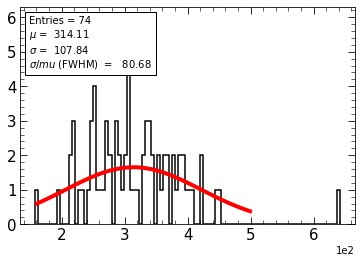

In [72]:
fe = fit_energy(np.array(data[0]['s2']), 100, (np.min(data[0]['s2']), np.max(data[0]['s2'])))
plot_fit_energy(fe)
eres, err, eres_qbb, sigma, mean = eres_err(fe)
eres_by_thresh.append(eres)
eres_qbb_by_thresh.append(eres_qbb)
eres_err_by_thresh.append(err)
mean_by_thresh.append(mean)
sigma_by_thresh.append(sigma)

In [ ]:
np.shape(data[0]['s2'])

In [ ]:
import json

In [ ]:
file_name = 'data/data_09112022.txt'
with open(file_name) as f:
    this_data = f.read()
this_data = json.loads(this_data)

In [ ]:
this_data[0].keys()

In [ ]:
# Get data by SiPM Thresholds
sipm_thresholds = []
eres_by_thresh = [] #[sthresh,d]
eres_err_by_sthresh = []
d = 500
for cuts in this_data:
    if cuts['d'] == d:
        sipm_thresholds.append(cuts['sthresh'])
        eres_by_thresh.append(cuts['eres'])

In [ ]:
plt.plot(sipm_thresholds, eres_by_thresh)

In [ ]:
sipm_thresholds = [1,2,5]
d_cuts = [10,100,1200]
nevents = 400
data = []
for sthresh in sipm_thresholds:
    for d_cut in d_cuts:
        s2_data = []
        outer_data = []
        for event in range(nevents):
            within_lm_radius = xya.get_nearby_sipm_inds(sipm_xys[max_sipms[event]], d_cut, sipm_xys)
            sipms_within_d = np.sum(sipms_s2[event,within_lm_radius,:], axis=1)
            sipms_d_s_thresh = sipms_within_d[sipms_within_d > sthresh]
            s2_data.append(np.sum(sipms_d_s_thresh))
        data.append({'sthresh':sthresh, 'd':d_cut, 's2':s2_data, 'outer':outer_data})

In [ ]:
for cuts in data:
    plt.hist(cuts['s2'], label='sthresh='+str(cuts['sthresh'])+', d<'+str(cuts['d']), bins=20)
    plt.xlabel('Charge')
    plt.legend()
    plt.show()

In [ ]:
np.shape(sipm_xys[max_sipms[event]])

In [ ]:
np.shape(sipm_xys)

In [ ]:
np.shape(max_sipms_outer)

In [58]:
max_sipms = np.argmax(np.sum(sipms_s2, axis=2), axis=1)
max_sipms_outer = np.argmax(np.sum(sipms_outer, axis=2), axis=1)

In [38]:
output = [{"sthresh": 2, "d": 1200, "s2": [1942.9547747207712, 1320.1517265886218, 983.0311755585466, 1372.4849077677306, 1292.916611472136, 1176.051827401067, 1358.483868054544, 1297.3489957985635, 1390.0213099587027, 1305.0051200619073, 1139.4764063778562, 1289.5616221035075, 925.5504243670056, 1222.1083017161875, 1311.6434427206555, 966.4713098550512, 1500.584687147485, 1369.1884301913722, 1264.4481262860018, 1512.7190342157485, 1051.491287412372, 1097.3875822083658, 1224.661831913626, 1219.616901462268, 1245.2278067676034, 1389.941768174847, 1179.079058345623, 1413.208698389466, 1385.109818201883, 1355.065179992432, 1102.98881007741, 1353.2822345036295, 1455.3505637405235, 1265.5800544273861, 1187.1122585519515, 1346.3747820575027, 1265.5869845502652, 1390.6159675512563, 1131.9151719099318, 1537.7475089361164, 1329.0714418264367, 1270.9835436986239, 1294.1851717702189, 1078.5094995733095, 1136.900608772169, 1252.337105263102, 1467.1464903269855, 1120.6643544704575, 1199.682300521991, 1425.5681955150717, 1203.542894380251, 1300.346847929614, 1389.9976135115353, 1301.4140486871602, 1129.2315543272948, 1319.9622515130525, 1129.9547211455397, 1035.4541565180714, 1488.0804704266225, 1132.2544171794905, 1263.2453892470005, 1341.7989354704446, 902.4536622200875, 1102.4726584135376, 1456.1264303303267, 1315.6633987163211, 1280.3582323926871], "outer": [271.23130164829166, 264.3768590519409, 231.4875895394814, 249.345922079977, 273.0694256805855, 278.8828754384406, 274.25829320984496, 266.9313182362149, 296.94570653693205, 220.28981857701692, 267.5807229114755, 269.8905592481075, 230.2786921964914, 299.67398795879325, 224.04703116946308, 260.25565249028176, 264.310038960072, 240.63860679938497, 252.14520853244704, 292.2605664699134, 240.24666486404348, 286.3981778047293, 260.889523047689, 237.284273251338, 218.39528316461596, 238.73252281190182, 298.1313820532723, 240.69210244753043, 251.2151555933488, 222.13361116930733, 241.5957855826502, 274.9576637962335, 221.1188515514351, 289.67809821922606, 203.6466645003438, 244.481312107546, 300.7883146974892, 234.03724052221483, 238.99931777338452, 242.01401351589755, 270.3207902333299, 230.1690636290916, 254.0093535089871, 218.2086024567489, 254.1561666794948, 243.17530423746612, 269.4993244483403, 274.1875756113447, 254.59596529153194, 281.2380121074627, 263.6641766948661, 223.02919607278432, 219.81186963180176, 259.43131790683924, 259.1922607370001, 257.0678082022084, 216.22798195170802, 208.79794901714092, 248.7500437228075, 207.02116981821666, 273.21938171925916, 205.0694399583211, 227.77817948547278, 276.57538197598586, 339.33590402460476, 184.0826261116108, 224.95460163927416]}]

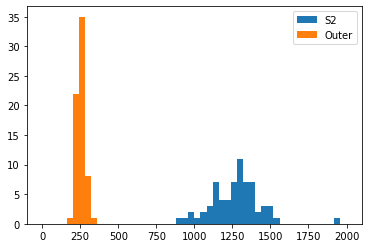

In [47]:
bins = 50
plot_range=(0,2000)
plt.hist(output[0]['s2'], label='S2', bins=bins, range=plot_range)
plt.hist(output[0]['outer'], label='Outer', bins=bins, range=plot_range)
plt.legend()